# Robustness of model (fraction of HI titers per season)
We will evaluate the performance of the proposed AdaBoost model over 14 test seasons from 2014NH to 2020SH, where we will condiser a subset of training data containing only 20-80% randomly selected HI titers in each historical season from 2003NH up to the test season.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "GIAG010101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',   # virus passage category
                 'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

perc_titers_train_all = [80, 60, 40, 20]   # percentage of HI titers per season in training dataset

n_run_start = 0   # No. of simulation runs as well as
n_run_end   = 50   # seed for the random selection of HI titers

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig4_robustness/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
results_fn = path_result + "SuppFig4a_robustness_rndTitersTrainSeason.csv"   # to save performance scores for test dataset
fig_fn     = path_result + 'SuppFig4a_robustness_rndTitersTrainSeason.svg'   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and validation datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and validate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern of Southern Hemisphere season such as "2015NH"
> - perc_titers_train (int): indicator for % of randomly selected HI titers in each historical season
> - run (int): random number for selection of perc_titers_train

> **Returns**
> - season (str)
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season

In [5]:
def train_test_season(season, perc_titers_train, run):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.rndTitersTrainSeason_seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']],
                                                                                 test_season=season,
                                                                                 titers_train=perc_titers_train,
                                                                                 random_state=run)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    '''
    Target (NHTs)
    '''
    y_train = data_train.nht.values
    y_test  = data_test.nht.values


    del X_train_meta, X_test_meta, data_train, data_test
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    y_train,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'run', 'titers_train', 'season']
    col_values = [mut_mat, model_name, metadata, run, f'{perc_titers_train}%', season]
    utilities.compute_scores(y_test, results['pred_test'], results_fn, col=cols, col_val=col_values)
    
    return season, y_test, results['pred_test']

## Performance of the model
- For each of the 50 runs
    - For fraction of titers from 80% to 20%
        - For each test season from 2014NH to 2020SH
            - Split the data into training and test datasets
            - Prepare encoded inputs (genetic difference and metadata features)
            - Train and evaluate the model
            - Compute predictive performance
            - Save the predictions
        - Compute average predictive performance

In [6]:
'''
Number of simulation (Monte-carlo) runs and
Random selection of titers per season in training dataset depends on this number used as SEED
'''
for run in range(n_run_start, n_run_end):
    
    '''
    Percentage of HI titers in training dataset
    '''
    for perc_titers_train in perc_titers_train_all:
        print("run: ", run,
              ",   titers per season for training: ", perc_titers_train)
        
        # train test for each test season in parallel
        result = Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season, perc_titers_train, run) for test_season in Test_Seasons)

        # get results
        seasons, actual_all, predict_all = zip(*result)

        
        '''
        Micro-average over seasons
        '''
        actual  = np.concatenate(actual_all)
        predict = np.concatenate(predict_all)

        # Test scores
        cols       = ['mut_mat', 'model', 'metadata', 'run', 'titers_train', 'season']
        col_values = [mut_mat, model_name, metadata, run, f'{perc_titers_train}%', 'Average']
        utilities.compute_scores(actual, predict, results_fn, col=cols, col_val=col_values)
        
        #################################
        # loop over perc_titers_train end
        #################################
    
    
    ######################
    # loop over n_runs end
    ######################

run:  0 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 12:40:26.741512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 12:40:27.249138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 12:40:27.814458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Time for training: 210.31275963783264
Time for training: 349.75616669654846
Time for training: 538.4092428684235
Time for training: 741.643625497818
Time for training: 833.1280777454376
Time for training: 919.5461955070496
Time for training: 1038.4837243556976
Time for training: 1346.3838350772858
Time for training: 1462.341225385666
Time for training: 1535.9995467662811


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.0min remaining:  5.7min


Time for training: 1658.1582984924316
Time for training: 1940.8005983829498
Time for training: 2287.3319504261017
run:  0 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 13:27:17.530757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:27:17.932769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:27:18.279135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2686.9431524276733
Time for training: 137.524067401886
Time for training: 214.1939742565155
Time for training: 342.8471760749817
Time for training: 470.98199939727783
Time for training: 541.6575365066528
Time for training: 594.9321942329407
Time for training: 673.243611574173
Time for training: 848.8335483074188
Time for training: 937.128350019455


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 977.2196562290192
Time for training: 1058.4218246936798
Time for training: 1223.1590871810913
run:  0 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 13:56:10.865210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:56:11.392988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:56:11.790509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1420.1645393371582
Time for training: 64.88093757629395
Time for training: 1637.6121418476105
Time for training: 112.58360457420349
Time for training: 177.17771244049072
Time for training: 236.20812702178955
Time for training: 276.62364745140076
Time for training: 305.08507084846497
Time for training: 340.05183506011963


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.4min remaining:  1.9min


Time for training: 440.01998496055603
Time for training: 475.1005234718323
Time for training: 520.4179787635803
Time for training: 546.3393166065216
run:  0 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 14:11:27.156013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 14:11:27.708523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 14:11:28.081992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  1 ,   titers per season for training:  80
Time for training: 630.1963768005371
Time for training: 17.985682249069214
Time for training: 204.59049153327942
Time for training: 751.4198267459869
Time for training: 27.774463415145874
Time for training: 333.1648180484772
Time for training: 849.8711671829224
Time for training: 51.94111943244934
Time for training: 523.1577064990997
Time for training: 67.87187552452087
Time for training: 695.6870815753937
Time for training: 91.36186146736145
Time for training: 828.0068311691284
Time for training: 98.84108662605286
Time for training: 917.3784852027893
Time for training: 108.18112564086914
Time for training: 1013.1671702861786
Time for training: 142.14417266845703
Time for training: 1351.8353674411774
Time for training: 154.0668261051178
Time for training: 1445.3108656406403
Time for training: 165.65244507789612
Time for training: 1553.3967382907867


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 176.1581175327301
Time for training: 1688.550112247467
Time for training: 203.6318781375885
Time for training: 1916.1876668930054
run:  1 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 15:01:29.065343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:01:29.306078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:01:29.985624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 246.04095482826233
Time for training: 2286.549439430237
Time for training: 124.69449377059937
Time for training: 273.76361775398254
Time for training: 2574.2321786880493
Time for training: 197.33644366264343
Time for training: 342.09634828567505
Time for training: 452.0335261821747
Time for training: 532.4859688282013
Time for training: 595.6529664993286
Time for training: 664.6089878082275
Time for training: 848.127715587616
Time for training: 931.0270617008209


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 981.2803478240967
Time for training: 1067.1874685287476
Time for training: 1222.895740032196
run:  1 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 15:30:18.397061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:30:18.982167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:30:19.314770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1427.9344494342804
Time for training: 66.60610699653625
Time for training: 115.32117080688477
Time for training: 175.19278073310852
Time for training: 238.46727848052979
Time for training: 276.2550320625305
Time for training: 306.34362959861755
Time for training: 346.2314484119415


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 442.01626229286194
Time for training: 494.95521545410156
Time for training: 511.0376591682434
Time for training: 553.2184963226318


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  1 ,   titers per season for training:  20


2023-10-11 15:45:48.059888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:45:48.546663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:45:49.160139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  2 ,   titers per season for training:  80
Time for training: 1633.6620309352875
Time for training: 636.6814050674438
Time for training: 17.553025722503662
Time for training: 208.38179850578308
Time for training: 744.0603590011597
Time for training: 28.32741117477417
Time for training: 338.85889983177185
Time for training: 861.5941367149353
Time for training: 44.58420181274414
Time for training: 519.0300130844116
Time for training: 68.91893410682678
Time for training: 706.1226637363434
Time for training: 89.62938189506531
Time for training: 813.7493078708649
Time for training: 100.56908178329468
Time for training: 871.1919631958008
Time for training: 110.00507164001465
Time for training: 995.7065229415894
Time for training: 145.78386163711548
Time for training: 1296.831643819809
Time for training: 157.44147515296936
Time for training: 1452.300401210785
Time for training: 169.30247688293457
Time for training: 1504.9701180458069


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.7min remaining:  5.5min


Time for training: 183.04225707054138
Time for training: 1646.9015312194824
Time for training: 215.30252480506897
Time for training: 1872.5382339954376
Time for training: 252.3974859714508
Time for training: 2222.028924226761
run:  2 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 16:36:10.782541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 16:36:11.287108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 16:36:11.850117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 282.9915597438812
Time for training: 2584.0868973731995
Time for training: 126.98648858070374
Time for training: 210.8791275024414
Time for training: 344.18409848213196
Time for training: 452.6677198410034
Time for training: 523.4952838420868
Time for training: 580.5582778453827
Time for training: 655.2817530632019
Time for training: 846.1230046749115


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.2min remaining:  3.5min


Time for training: 917.0006597042084
Time for training: 953.6207363605499
Time for training: 1037.5688700675964
Time for training: 1194.7242295742035
run:  2 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 17:04:41.857490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 17:04:42.390628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 17:04:42.634106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1392.6999442577362
Time for training: 58.87414216995239
Time for training: 1615.6669642925262
Time for training: 116.23271536827087
Time for training: 178.80210995674133
Time for training: 233.19061374664307
Time for training: 271.1597955226898
Time for training: 303.1910169124603


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.0min remaining:  1.8min


Time for training: 341.2705581188202
Time for training: 433.7283854484558
Time for training: 481.36497235298157
Time for training: 511.96156311035156
Time for training: 546.7041192054749
run:  2 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 17:19:39.265628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 17:19:39.663518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 17:19:40.204884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  3 ,   titers per season for training:  80
Time for training: 606.6186943054199
Time for training: 17.090574502944946
Time for training: 207.26440453529358
Time for training: 732.9285070896149
Time for training: 28.32596468925476
Time for training: 339.3666236400604
Time for training: 830.4513339996338
Time for training: 51.08038091659546
Time for training: 538.9438927173615
Time for training: 65.8408374786377
Time for training: 712.782256603241
Time for training: 89.63841891288757
Time for training: 831.5529699325562
Time for training: 98.47958183288574
Time for training: 889.0673997402191
Time for training: 109.24061512947083
Time for training: 1023.5772562026978
Time for training: 137.17004656791687
Time for training: 1346.4866042137146
Time for training: 150.475576877594
Time for training: 1423.2329127788544
Time for training: 162.81005549430847
Time for training: 1535.2709283828735


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.2min remaining:  5.5min


Time for training: 174.03641843795776
Time for training: 1667.4124858379364
Time for training: 202.00845956802368
Time for training: 1900.3667948246002
Time for training: 237.75431394577026
Time for training: 2270.7444264888763
run:  3 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 18:10:45.613413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:10:45.964071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:10:46.473815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 277.6167643070221
Time for training: 2633.8238990306854
Time for training: 127.31201767921448
Time for training: 226.58880424499512
Time for training: 350.84727239608765
Time for training: 472.7551918029785
Time for training: 561.4704761505127
Time for training: 605.7459280490875
Time for training: 666.585569858551
Time for training: 849.5851547718048
Time for training: 921.4615209102631


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 980.5042474269867
Time for training: 1047.1454713344574
Time for training: 1208.1155893802643
run:  3 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 18:39:35.600540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:39:36.237906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:39:36.630214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1437.4459631443024
Time for training: 67.97401762008667
Time for training: 1635.2016410827637
Time for training: 118.44406700134277
Time for training: 196.523188829422
Time for training: 250.7299885749817
Time for training: 296.49741649627686
Time for training: 322.3946602344513
Time for training: 349.0220923423767


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 458.9075541496277
Time for training: 495.5822458267212
Time for training: 544.3037173748016
Time for training: 571.7966418266296


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  3 ,   titers per season for training:  20


2023-10-11 18:55:23.778861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:55:24.359374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 18:55:24.809912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  4 ,   titers per season for training:  80
Time for training: 650.1670935153961
Time for training: 17.514146089553833
Time for training: 201.9966447353363
Time for training: 751.3459575176239
Time for training: 32.60606098175049
Time for training: 327.08552861213684
Time for training: 881.8033611774445
Time for training: 46.873401403427124
Time for training: 524.9587917327881
Time for training: 68.57949900627136
Time for training: 697.001827955246
Time for training: 88.89755606651306
Time for training: 827.931309223175
Time for training: 96.3827452659607
Time for training: 896.707409620285
Time for training: 107.20019960403442
Time for training: 1007.9901149272919
Time for training: 142.6634500026703
Time for training: 1328.3802466392517
Time for training: 155.91071367263794
Time for training: 1453.6937475204468
Time for training: 162.99531292915344
Time for training: 1527.3506064414978


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.9min remaining:  5.5min


Time for training: 177.3153669834137
Time for training: 1619.2260987758636
Time for training: 201.4216296672821
Time for training: 1878.6404848098755
Time for training: 238.25978755950928
Time for training: 2181.518869161606
run:  4 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 19:45:52.637920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 19:45:52.904747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 19:45:53.503210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 276.76803946495056
Time for training: 2602.1790981292725
Time for training: 124.60950183868408
Time for training: 211.38515448570251
Time for training: 344.85684180259705
Time for training: 453.64828872680664
Time for training: 547.2168076038361
Time for training: 603.5844507217407
Time for training: 683.7244148254395
Time for training: 871.401358127594
Time for training: 943.8996167182922


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.2min remaining:  3.7min


Time for training: 1041.1227972507477
Time for training: 1076.1850242614746
Time for training: 1250.7030775547028
run:  4 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 20:15:35.688321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:15:35.688333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:15:35.689016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1448.7693479061127
Time for training: 60.42421078681946
Time for training: 1686.2886197566986
Time for training: 104.7671115398407
Time for training: 183.17127680778503
Time for training: 246.47790694236755
Time for training: 289.4605550765991
Time for training: 313.516259431839
Time for training: 350.56744050979614


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 12.1min remaining:  2.0min


Time for training: 458.4518859386444
Time for training: 504.7771337032318
Time for training: 523.6912667751312
Time for training: 581.2168021202087


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  4 ,   titers per season for training:  20


2023-10-11 20:31:19.032202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:31:19.032985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:31:19.032984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

run:  5 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 20:36:45.300563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 281.5532648563385
Time for training: 661.8115968704224
Time for training: 17.46205163002014
Time for training: 211.94081807136536
Time for training: 761.7503046989441
Time for training: 27.84115743637085
Time for training: 349.7914311885834
Time for training: 875.5295097827911
Time for training: 52.99039077758789
Time for training: 543.6544485092163
Time for training: 67.59722352027893
Time for training: 716.6634531021118
Time for training: 88.47968816757202
Time for training: 842.344714641571
Time for training: 97.67332124710083
Time for training: 928.4938688278198
Time for training: 106.747079372406
Time for training: 1022.0059702396393
Time for training: 143.44712924957275
Time for training: 1344.9197595119476
Time for training: 156.87248826026917
Time for training: 1479.6900353431702
Time for training: 166.38675379753113
Time for training: 1529.9086816310883


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.9min remaining:  5.6min


Time for training: 178.15294313430786
Time for training: 1659.9992473125458
Time for training: 206.24384808540344
Time for training: 1936.5873482227325
Time for training: 250.87342929840088
Time for training: 2312.386328935623
run:  5 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 21:22:11.474260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 21:22:11.474266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 21:22:11.474947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2606.52623796463
Time for training: 139.26225781440735
Time for training: 228.67818570137024
Time for training: 345.20866203308105
Time for training: 469.67635846138
Time for training: 540.7398114204407
Time for training: 603.8637804985046
Time for training: 666.1727139949799
Time for training: 855.3995802402496
Time for training: 929.5149571895599


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.6min remaining:  3.6min


Time for training: 1005.0665335655212
Time for training: 1068.3273797035217
Time for training: 1215.19788479805
run:  5 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 21:50:52.104478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 21:50:52.357592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 21:50:52.903874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1402.9709112644196
Time for training: 61.65899443626404
Time for training: 1626.2966704368591
Time for training: 110.55930852890015
Time for training: 191.32476234436035
Time for training: 249.33118271827698
Time for training: 287.4025695323944
Time for training: 309.38901138305664


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 355.94808626174927
Time for training: 443.8975875377655
Time for training: 485.6948437690735
Time for training: 514.3916115760803
run:  5 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 22:05:54.412153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 22:05:54.965113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 22:05:55.556655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  6 ,   titers per season for training:  80
Time for training: 553.5126075744629
Time for training: 17.622242212295532
Time for training: 205.90800666809082
Time for training: 635.0324664115906
Time for training: 27.172467947006226
Time for training: 332.39578127861023
Time for training: 718.9922397136688
Time for training: 50.706509828567505
Time for training: 519.8832085132599
Time for training: 835.4736969470978
Time for training: 67.86065292358398
Time for training: 709.9412047863007
Time for training: 91.08273220062256
Time for training: 815.4957163333893
Time for training: 99.58097052574158
Time for training: 893.2277512550354
Time for training: 109.55876803398132
Time for training: 1008.0244436264038
Time for training: 142.49230241775513
Time for training: 1286.4300212860107
Time for training: 154.51391792297363
Time for training: 1396.3345787525177
Time for training: 164.16217827796936
Time for training: 1506.7287204265594


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.2min remaining:  5.4min


Time for training: 177.88962531089783
Time for training: 1616.4080595970154
Time for training: 202.87109994888306
Time for training: 1840.541624546051
Time for training: 241.08427023887634
Time for training: 2235.4972445964813
run:  6 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 22:56:31.931249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 22:56:31.931250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 22:56:32.140875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.04171323776245
Time for training: 2602.8493580818176
Time for training: 112.59757852554321
Time for training: 214.7596414089203
Time for training: 335.95378851890564
Time for training: 453.3529326915741
Time for training: 517.7191786766052
Time for training: 576.762885093689
Time for training: 652.8192090988159
Time for training: 839.3645913600922
Time for training: 909.3503470420837


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.4min remaining:  3.6min


Time for training: 1011.019802570343
Time for training: 1062.6824128627777
Time for training: 1203.7177948951721
run:  6 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 23:25:36.677674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 23:25:37.260262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 23:25:37.664508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1449.7214150428772
Time for training: 69.43809843063354
Time for training: 1651.240596294403
Time for training: 107.88543915748596
Time for training: 184.08243584632874
Time for training: 245.66992378234863
Time for training: 289.4989538192749
Time for training: 311.5264461040497
Time for training: 348.76931047439575


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 448.46451234817505
Time for training: 495.1084372997284
Time for training: 530.0852825641632
Time for training: 575.3717935085297
run:  6 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-11 23:41:25.760863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 23:41:26.183165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 23:41:26.776510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  7 ,   titers per season for training:  80
Time for training: 662.5851528644562
Time for training: 17.729020595550537
Time for training: 206.8594512939453
Time for training: 779.9298222064972
Time for training: 27.562273263931274
Time for training: 340.6846363544464
Time for training: 881.9322073459625
Time for training: 43.94810628890991
Time for training: 534.8755962848663
Time for training: 66.19773316383362
Time for training: 722.13321352005
Time for training: 89.19294548034668
Time for training: 827.0299859046936
Time for training: 96.52628803253174
Time for training: 907.9763712882996
Time for training: 109.24095749855042
Time for training: 1006.5729763507843
Time for training: 139.5155577659607
Time for training: 1324.142183303833
Time for training: 151.3224778175354
Time for training: 1427.8255815505981
Time for training: 165.067156791687
Time for training: 1536.9415225982666


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 178.6666407585144
Time for training: 1648.7423522472382
Time for training: 204.94902205467224
Time for training: 1915.4019100666046
Time for training: 244.81574249267578
Time for training: 2236.9062509536743
run:  7 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 00:32:12.915158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 00:32:12.915173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 00:32:13.410755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 282.62194442749023
Time for training: 2608.3288066387177
Time for training: 138.28323101997375
Time for training: 215.39340949058533
Time for training: 342.3407139778137
Time for training: 465.72029519081116
Time for training: 531.7847945690155
Time for training: 576.0213730335236
Time for training: 661.4181890487671
Time for training: 869.9334075450897
Time for training: 940.3299250602722


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 993.7596638202667
Time for training: 1076.2882306575775
Time for training: 1222.8043467998505
run:  7 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 01:01:41.104746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 01:01:41.640480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 01:01:41.938131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1442.263524055481
Time for training: 58.86268067359924
Time for training: 1676.7879526615143
Time for training: 123.3626708984375
Time for training: 188.6178698539734
Time for training: 248.99308848381042
Time for training: 288.63663506507874
Time for training: 324.6830337047577
Time for training: 356.1969916820526


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 463.96758008003235
Time for training: 499.1515488624573
Time for training: 542.5049245357513
Time for training: 584.3130097389221
run:  7 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 01:17:32.310838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 01:17:32.734115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 01:17:33.223394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  8 ,   titers per season for training:  80
Time for training: 658.9183139801025
Time for training: 17.798463821411133
Time for training: 208.75724530220032
Time for training: 769.013267993927
Time for training: 28.35534358024597
Time for training: 336.83200311660767
Time for training: 887.4507462978363
Time for training: 44.754369258880615
Time for training: 528.5487062931061
Time for training: 66.79713535308838
Time for training: 705.9244952201843
Time for training: 89.30704307556152
Time for training: 830.0586857795715
Time for training: 97.43382120132446
Time for training: 917.7484011650085
Time for training: 109.10258364677429
Time for training: 1027.7270739078522
Time for training: 140.66154623031616
Time for training: 1324.984016418457
Time for training: 155.82716846466064
Time for training: 1433.093320608139
Time for training: 165.8410210609436
Time for training: 1539.1760561466217


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.0min remaining:  5.5min


Time for training: 180.20268630981445
Time for training: 1629.0676956176758
Time for training: 207.51819801330566
Time for training: 1884.4148018360138
Time for training: 249.3169708251953
Time for training: 2204.119276046753
run:  8 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 02:08:06.291294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:08:06.448775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:08:06.990809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 281.64015316963196
Time for training: 2601.2135190963745
Time for training: 125.1785159111023
Time for training: 213.9949016571045
Time for training: 336.70503211021423
Time for training: 451.45551443099976
Time for training: 518.1446313858032
Time for training: 584.5237309932709
Time for training: 643.047655582428
Time for training: 846.4037141799927


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 20.4min remaining:  3.4min


Time for training: 933.95960688591
Time for training: 979.8317382335663
Time for training: 998.7038974761963
Time for training: 1174.8599824905396
run:  8 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 02:36:35.545686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:36:35.813528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:36:36.375996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1394.8557035923004
Time for training: 66.84819602966309
Time for training: 1617.3719806671143
Time for training: 92.82955980300903
Time for training: 184.83693933486938
Time for training: 230.54355001449585
Time for training: 266.46096897125244
Time for training: 295.5008661746979
Time for training: 327.0168192386627


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 420.0974278450012
run:  8 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 13.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 02:50:14.950576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:50:15.409499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:50:15.985753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  9 ,   titers per season for training:  80


2023-10-12 02:54:51.167757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:54:51.640895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 02:54:52.194560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 730.0414681434631
Time for training: 79.88617730140686
Time for training: 758.8016488552094
Time for training: 101.73399782180786
Time for training: 109.40264582633972
Time for training: 144.29064178466797
Time for training: 149.43704533576965
Time for training: 152.38645124435425
Time for training: 166.64093947410583
Time for training: 207.62399792671204
Time for training: 214.61246156692505
Time for training: 246.2449426651001
Time for training: 216.78482913970947
Time for training: 328.9808123111725
Time for training: 521.5469386577606
Time for training: 703.9303901195526
Time for training: 804.6880612373352
Time for training: 891.8427767753601
Time for training: 1004.8325171470642
Time for training: 1316.0198819637299
Time for training: 1428.601218700409
Time for training: 1493.4520020484924


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.2min remaining:  5.4min


Time for training: 491.71049308776855
Time for training: 18.19460415840149
Time for training: 1630.5689101219177
Time for training: 529.1000850200653
Time for training: 27.26580262184143
Time for training: 1876.575495004654
Time for training: 529.2073304653168
Time for training: 46.07362461090088
Time for training: 2206.701238632202
run:  9 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 03:39:48.779692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 03:39:48.815380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 03:39:48.829855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 654.1127071380615
Time for training: 61.11254835128784
Time for training: 2575.8385396003723
Time for training: 125.27289342880249
Time for training: 211.40194845199585
Time for training: 345.2773902416229
Time for training: 480.576308965683
Time for training: 539.2644300460815
Time for training: 595.1947138309479
Time for training: 669.3467965126038


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 20.4min remaining:  3.4min


Time for training: 864.938502073288
Time for training: 902.5854697227478
Time for training: 996.1773316860199
Time for training: 1040.0544550418854
Time for training: 1172.2525987625122
run:  9 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 04:08:29.766249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 04:08:30.255880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 04:08:30.698281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1403.5889251232147
Time for training: 58.72812366485596
Time for training: 1630.5979671478271
Time for training: 116.40174698829651
Time for training: 191.09278964996338
Time for training: 235.94322443008423
Time for training: 283.9793813228607
Time for training: 308.38637804985046


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.0min remaining:  1.8min


Time for training: 332.056521654129
Time for training: 435.7445571422577
Time for training: 470.88636684417725
Time for training: 507.74762988090515
run:  9 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 14.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 04:22:51.642927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 04:22:51.899841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 04:22:52.222298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  10 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 561.7330522537231
Time for training: 18.309202432632446
Time for training: 209.16298842430115
Time for training: 612.3380243778229
Time for training: 23.843831777572632
Time for training: 344.5936529636383
Time for training: 748.3301949501038
Time for training: 42.87479519844055
Time for training: 527.0064992904663
Time for training: 819.8207406997681
Time for training: 69.88061165809631
Time for training: 697.3558702468872
Time for training: 89.04517769813538
Time for training: 830.4459595680237
Time for training: 96.2955870628357
Time for training: 916.4936475753784
Time for training: 105.67670845985413
Time for training: 1025.1792378425598
Time for training: 135.65425896644592
Time for training: 1340.038962841034
Time for training: 153.2259373664856
Time for training: 1444.0846779346466
Time for training: 165.47179889678955
Time for training: 1554.1921436786652


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.8min remaining:  5.5min


Time for training: 178.67262506484985
Time for training: 1643.69380402565
Time for training: 186.33517003059387
Time for training: 1881.4751060009003
Time for training: 239.47654104232788
Time for training: 2274.8341777324677
run:  10 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 05:14:02.787760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:14:03.404718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:14:03.924259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 275.9073951244354
Time for training: 2649.139054775238
Time for training: 114.21448969841003
Time for training: 213.19348788261414
Time for training: 341.1710834503174
Time for training: 444.68238592147827
Time for training: 529.9680728912354
Time for training: 585.0825486183167
Time for training: 668.1097455024719
Time for training: 852.2108340263367
Time for training: 932.1660432815552


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 978.5988142490387
Time for training: 1067.3779649734497
Time for training: 1223.6935577392578
run:  10 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 05:43:00.184471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:43:00.517339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:43:01.058451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1422.7705128192902
Time for training: 47.59394645690918
Time for training: 1647.6501033306122
Time for training: 107.51401567459106
Time for training: 178.29147124290466
Time for training: 237.77629446983337
Time for training: 276.0949139595032
Time for training: 301.1297583580017
Time for training: 340.64813208580017


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.4min remaining:  1.9min


Time for training: 440.19447565078735
Time for training: 484.3503656387329
Time for training: 519.9920210838318
Time for training: 550.837105512619
run:  10 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 05:58:13.876117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:58:14.262007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 05:58:14.897441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  11 ,   titers per season for training:  80
Time for training: 629.5347874164581
Time for training: 16.356504917144775
Time for training: 209.27468395233154
Time for training: 737.1637101173401
Time for training: 28.376220226287842
Time for training: 329.6688320636749
Time for training: 872.7566504478455
Time for training: 44.80445861816406
Time for training: 532.3592507839203
Time for training: 55.77224063873291
Time for training: 710.3152449131012
Time for training: 83.32897782325745
Time for training: 830.5566449165344
Time for training: 92.42727565765381
Time for training: 910.038711309433
Time for training: 98.69381785392761
Time for training: 1030.8215980529785
Time for training: 128.72412204742432
Time for training: 1310.8379878997803
Time for training: 150.92774319648743
Time for training: 1448.0997080802917
Time for training: 160.44741678237915
Time for training: 1528.4180524349213


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.1min remaining:  5.5min


Time for training: 169.17356824874878
Time for training: 1637.0674498081207
Time for training: 170.22461032867432
Time for training: 1893.7389750480652
Time for training: 217.67139196395874
Time for training: 2222.026604652405
run:  11 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 06:48:38.816742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 06:48:39.379279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 06:48:39.853416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 270.1350016593933
Time for training: 2605.946748495102
Time for training: 123.83769464492798
Time for training: 209.4171600341797
Time for training: 338.79454708099365
Time for training: 455.45421028137207
Time for training: 529.0131170749664
Time for training: 579.5469837188721
Time for training: 650.5814881324768
Time for training: 858.597772359848
Time for training: 924.9067416191101


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 965.7492203712463
Time for training: 1035.3776030540466
Time for training: 1209.595166683197
run:  11 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 27.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 07:16:28.219675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:16:28.673204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:16:29.164325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1375.7991561889648
Time for training: 64.33543729782104
Time for training: 1600.2510471343994
Time for training: 104.68953132629395
Time for training: 180.43102955818176
Time for training: 241.950847864151
Time for training: 274.4167628288269
Time for training: 301.7566246986389
Time for training: 347.51379442214966


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.7min remaining:  2.0min


Time for training: 438.06410813331604
Time for training: 475.1666769981384
Time for training: 509.0949184894562
Time for training: 547.2630116939545
run:  11 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 07:31:43.716162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:31:44.229063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:31:44.729934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  12 ,   titers per season for training:  80


2023-10-12 07:36:39.037630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:36:39.661802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:36:40.127940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 140.21205019950867
Time for training: 152.70372676849365
Time for training: 162.47749972343445
Time for training: 174.17260789871216
Time for training: 207.3404700756073
Time for training: 237.71340417861938
Time for training: 271.55915665626526
Time for training: 201.70939254760742
Time for training: 351.47056245803833
Time for training: 555.0613334178925
Time for training: 708.5550196170807
Time for training: 847.946070432663
Time for training: 923.8318648338318
Time for training: 1030.649566411972
Time for training: 647.903481721878
Time for training: 17.770711660385132
Time for training: 1311.9233622550964
Time for training: 731.9600601196289
Time for training: 32.633363485336304
Time for training: 1435.559461593628
Time for training: 853.8703992366791
Time for training: 44.57455372810364
Time for training: 1523.1084442138672


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.5min


Time for training: 75.3417158126831
Time for training: 1634.4725136756897
Time for training: 87.70297431945801
Time for training: 1899.2866032123566
Time for training: 95.61574625968933
Time for training: 2299.8571417331696
run:  12 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 08:22:20.853513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 08:22:20.853690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 08:22:20.854074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 105.42383289337158
Time for training: 2617.7370088100433
Time for training: 134.56877946853638
Time for training: 205.2883324623108
Time for training: 329.6112496852875
Time for training: 455.02967715263367
Time for training: 528.3106553554535
Time for training: 613.1463930606842
Time for training: 637.6994848251343
Time for training: 860.2959995269775
Time for training: 897.0003926753998


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.1min remaining:  3.5min


Time for training: 996.6788458824158
Time for training: 1035.86589717865
Time for training: 1189.395512342453
run:  12 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 08:51:06.503388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 08:51:06.872010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 08:51:07.276688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1404.6984026432037
Time for training: 57.646119117736816
Time for training: 1635.6245934963226
Time for training: 106.81046557426453
Time for training: 179.25111484527588
Time for training: 242.636887550354
Time for training: 278.70263934135437
Time for training: 307.40560007095337
Time for training: 347.93687319755554


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 449.5480737686157
Time for training: 490.5772156715393
Time for training: 518.7051317691803
Time for training: 560.6213366985321
run:  12 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 09:06:39.004306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 09:06:39.360639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 09:06:39.889686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  13 ,   titers per season for training:  80
Time for training: 644.8190386295319
Time for training: 18.17134404182434
Time for training: 206.43512225151062
Time for training: 752.754857301712
Time for training: 27.96285080909729
Time for training: 335.3794684410095
Time for training: 873.9682192802429
Time for training: 45.734169244766235
Time for training: 529.5401883125305
Time for training: 68.97416400909424
Time for training: 705.0649333000183
Time for training: 87.83393001556396
Time for training: 812.4086923599243
Time for training: 95.87781238555908
Time for training: 918.9963195323944
Time for training: 104.00758481025696
Time for training: 1017.0483658313751
Time for training: 137.93357372283936
Time for training: 1317.7214999198914
Time for training: 150.8049294948578
Time for training: 1450.0686259269714
Time for training: 158.207825422287
Time for training: 1512.547707080841


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.6min


Time for training: 173.48589515686035
Time for training: 1631.7748084068298
Time for training: 201.56348705291748
Time for training: 1907.3224053382874
Time for training: 240.85086250305176
Time for training: 2223.442094564438
run:  13 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 09:57:07.537630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 09:57:08.060286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 09:57:08.655864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 276.6623215675354
Time for training: 2598.6812036037445
Time for training: 124.7227258682251
Time for training: 210.87134861946106
Time for training: 345.0546078681946
Time for training: 451.64287185668945
Time for training: 526.4673252105713
Time for training: 581.9506220817566
Time for training: 663.5637302398682
Time for training: 842.4937796592712


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.4min remaining:  3.6min


Time for training: 942.6998209953308
Time for training: 969.6755011081696
Time for training: 1042.9698667526245
Time for training: 1204.0762321949005
run:  13 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 10:26:00.784314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 10:26:01.180638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 10:26:01.814698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1411.4896490573883
Time for training: 64.96138286590576
Time for training: 1639.415654182434
Time for training: 113.21699571609497
Time for training: 174.85277724266052
Time for training: 233.91025137901306
Time for training: 276.12282490730286
Time for training: 301.42271900177
Time for training: 339.89205026626587


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.7min remaining:  2.0min


Time for training: 433.57882714271545
Time for training: 476.4252848625183
Time for training: 507.7368993759155
Time for training: 555.5847976207733
run:  13 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 10:41:14.406271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 10:41:14.721851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 10:41:15.340982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  14 ,   titers per season for training:  80
Time for training: 648.341686964035
Time for training: 17.31449866294861
Time for training: 206.07576322555542
Time for training: 740.3653035163879
Time for training: 31.917487382888794
Time for training: 341.90719842910767
Time for training: 847.6022069454193
Time for training: 42.94408845901489
Time for training: 525.0249392986298
Time for training: 63.79554629325867
Time for training: 721.8363440036774
Time for training: 87.56566786766052
Time for training: 808.1798875331879
Time for training: 96.56299805641174
Time for training: 900.9403834342957
Time for training: 108.9320752620697
Time for training: 990.5543088912964
Time for training: 138.82144784927368
Time for training: 1291.6679272651672
Time for training: 153.31715321540833
Time for training: 1420.499339580536
Time for training: 161.59886693954468
Time for training: 1490.6739864349365


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.3min remaining:  5.4min


Time for training: 182.39050769805908
Time for training: 1619.2473697662354
Time for training: 206.60886430740356
Time for training: 1854.8075542449951
Time for training: 240.2038233280182
Time for training: 2198.535875558853
run:  14 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 11:30:49.210602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:30:49.571780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:30:50.053076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 276.8746597766876
Time for training: 2545.6041061878204
Time for training: 135.5712969303131
Time for training: 210.34912109375
Time for training: 340.497834444046
Time for training: 448.33599400520325
Time for training: 520.1806871891022
Time for training: 568.8740446567535
Time for training: 646.9243264198303
Time for training: 850.6437344551086


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.4min remaining:  3.6min


Time for training: 926.6879379749298
Time for training: 954.6223695278168
Time for training: 1035.224087715149
Time for training: 1203.9772720336914
run:  14 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 11:59:03.352448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:59:04.026043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:59:04.372269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1403.8608956336975
Time for training: 57.860522747039795
Time for training: 1608.418274641037
Time for training: 112.3023509979248
Time for training: 174.46208786964417
Time for training: 229.09849047660828
Time for training: 271.5110740661621
Time for training: 297.22611808776855


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.1min remaining:  1.9min


Time for training: 337.9023561477661
Time for training: 441.8600244522095
Time for training: 481.35385060310364
Time for training: 496.2965977191925
Time for training: 539.5677330493927
run:  14 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 12:14:10.401144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 12:14:11.056063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 12:14:11.526844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  15 ,   titers per season for training:  80


2023-10-12 12:19:06.421859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 12:19:06.825426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 12:19:07.255652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Time for training: 149.9287815093994
Time for training: 165.8883936405182
Time for training: 174.26244163513184
Time for training: 195.3756513595581
Time for training: 240.73782420158386
Time for training: 267.81117248535156
Time for training: 209.5017328262329
Time for training: 341.3508503437042
Time for training: 541.6257808208466
Time for training: 719.5606317520142
Time for training: 821.762766122818
Time for training: 906.2632331848145
Time for training: 623.1427030563354
Time for training: 17.09690546989441
Time for training: 1019.3144152164459
Time for training: 728.9463529586792
Time for training: 28.040486097335815
Time for training: 1343.4528465270996
Time for training: 840.7408940792084
Time for training: 43.90649890899658
Time for training: 1443.066524028778
Time for training: 66.62314534187317
Time for training: 1534.971795797348


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 87.82523655891418
Time for training: 1655.7210998535156
Time for training: 96.9895670413971
Time for training: 1912.94961643219
Time for training: 103.6224913597107
Time for training: 2275.1220281124115
run:  15 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 13:04:46.162938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:04:46.163303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:04:46.229505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 138.53162288665771
Time for training: 2617.7555437088013
Time for training: 114.02647829055786
Time for training: 216.79247307777405
Time for training: 343.79692935943604
Time for training: 457.2704300880432
Time for training: 541.9623694419861
Time for training: 585.9674026966095
Time for training: 655.2868835926056
Time for training: 852.9515659809113
Time for training: 924.9604082107544


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 983.1350848674774
Time for training: 1032.0852575302124
Time for training: 1210.191591501236
run:  15 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 13:33:42.216954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:33:42.669280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:33:43.097039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1432.2330527305603
Time for training: 65.87272715568542
Time for training: 1644.4413211345673
Time for training: 110.6489610671997
Time for training: 181.73377561569214
Time for training: 248.08828282356262
Time for training: 283.9581563472748
Time for training: 316.5990626811981
Time for training: 358.9012682437897


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 456.1426043510437
Time for training: 499.6240701675415
Time for training: 532.8316488265991
Time for training: 562.8338420391083
run:  15 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 13:49:02.771283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:49:03.280587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:49:03.718748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  16 ,   titers per season for training:  80
Time for training: 646.4802203178406
Time for training: 17.836225032806396
Time for training: 208.89542055130005
Time for training: 741.850367307663
Time for training: 28.352050304412842
Time for training: 332.2154631614685
Time for training: 856.763420343399
Time for training: 43.92351293563843
Time for training: 525.6029181480408
Time for training: 59.94786047935486
Time for training: 703.9328119754791
Time for training: 88.2060341835022
Time for training: 834.4032907485962
Time for training: 96.04575824737549
Time for training: 908.2949125766754
Time for training: 109.58159637451172
Time for training: 1016.3867766857147
Time for training: 143.10607075691223
Time for training: 1331.8068568706512
Time for training: 156.14245343208313
Time for training: 1470.100660085678
Time for training: 166.81025052070618
Time for training: 1534.8119974136353


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.1min remaining:  5.5min


Time for training: 180.34390950202942
Time for training: 1657.4469501972198
Time for training: 206.00427389144897
Time for training: 1897.0841610431671
Time for training: 244.55657839775085
Time for training: 2270.7227725982666
run:  16 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 14:39:37.216659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 14:39:37.501933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 14:39:37.923352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 278.7658305168152
Time for training: 2605.205331325531
Time for training: 128.44675517082214
Time for training: 213.0212345123291
Time for training: 348.7956120967865
Time for training: 458.4001019001007
Time for training: 538.0754520893097
Time for training: 615.8260896205902
Time for training: 673.0171015262604
Time for training: 881.4372746944427


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.0min remaining:  3.7min


Time for training: 968.89865899086
Time for training: 1007.5373513698578
Time for training: 1088.497933626175
Time for training: 1241.0588715076447
run:  16 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 15:09:13.770804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:09:14.214809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:09:14.708386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1468.374505519867
Time for training: 59.6797137260437
Time for training: 1683.889400959015
Time for training: 116.34269642829895
Time for training: 180.33444142341614
Time for training: 241.5449697971344
Time for training: 290.3737437725067
Time for training: 321.0881495475769
Time for training: 361.40739727020264


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 12.0min remaining:  2.0min


Time for training: 467.0028223991394
Time for training: 502.3093898296356
Time for training: 540.3659155368805
Time for training: 568.0788321495056
run:  16 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 15:24:55.075711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:24:55.664856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 15:24:56.143381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  17 ,   titers per season for training:  80
Time for training: 667.3793387413025
Time for training: 17.731030225753784
Time for training: 205.5122423171997
Time for training: 768.8390033245087
Time for training: 27.30034613609314
Time for training: 325.4245183467865
Time for training: 876.6576197147369
Time for training: 51.31902313232422
Time for training: 521.7805676460266
Time for training: 60.49816393852234
Time for training: 717.0628981590271
Time for training: 91.33917045593262
Time for training: 826.8592345714569
Time for training: 98.03476428985596
Time for training: 898.1052758693695
Time for training: 109.79220628738403
Time for training: 1015.094064950943
Time for training: 144.4731481075287
Time for training: 1290.604528427124
Time for training: 155.79066371917725
Time for training: 1410.144234418869
Time for training: 168.0695960521698
Time for training: 1507.1038711071014
Time for training: 181.19079303741455
Time for training: 1620.23717212677


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.4min remaining:  5.6min


Time for training: 206.83726119995117
Time for training: 1910.0877621173859
Time for training: 243.95205974578857
Time for training: 2223.58115029335
run:  17 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 16:14:43.943897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:14:44.402164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:14:45.039492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 275.9873893260956
Time for training: 2569.4835035800934
Time for training: 135.22853875160217
Time for training: 210.3227915763855
Time for training: 342.10129141807556
Time for training: 467.9526286125183
Time for training: 539.3859498500824
Time for training: 596.3235297203064
Time for training: 640.2090570926666
Time for training: 846.4253287315369
Time for training: 915.217887878418


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.3min remaining:  3.6min


Time for training: 962.0207250118256
Time for training: 1035.0264229774475
Time for training: 1200.7202928066254
run:  17 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 16:43:18.466867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:43:19.463815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:43:19.890716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1415.9354491233826
Time for training: 69.52321147918701
Time for training: 113.9611508846283
Time for training: 1622.4498343467712
Time for training: 185.5660994052887
Time for training: 240.58724761009216
Time for training: 285.99128818511963
Time for training: 305.07125997543335
Time for training: 339.1077218055725


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.4min remaining:  1.9min


Time for training: 446.6408371925354
Time for training: 494.3776903152466
Time for training: 514.4494736194611
Time for training: 553.3752911090851
run:  17 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 16:58:42.106269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:58:42.533324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:58:42.956938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  18 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 630.0124979019165
Time for training: 17.53958797454834
Time for training: 209.88992261886597
Time for training: 748.3554320335388
Time for training: 32.62621808052063
Time for training: 328.72378039360046
Time for training: 859.0576474666595
Time for training: 49.65575981140137
Time for training: 523.4283576011658
Time for training: 67.34249114990234
Time for training: 695.2521245479584
Time for training: 88.22356176376343
Time for training: 810.0599589347839
Time for training: 99.61241579055786
Time for training: 913.2594199180603
Time for training: 105.8892092704773
Time for training: 988.2495496273041
Time for training: 137.62949657440186
Time for training: 1312.9869384765625
Time for training: 155.7983913421631
Time for training: 1399.0804333686829
Time for training: 160.27702164649963
Time for training: 1516.8574841022491


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.7min remaining:  5.4min


Time for training: 174.17624378204346
Time for training: 1622.5578939914703
Time for training: 199.37706303596497
Time for training: 1868.566701412201
Time for training: 237.8894338607788
Time for training: 2160.5747838020325
run:  18 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 17:48:25.934289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 17:48:26.600986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 17:48:26.957675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 268.6946659088135
Time for training: 2569.8466997146606
Time for training: 123.25543880462646
Time for training: 211.97662377357483
Time for training: 335.9202015399933
Time for training: 467.36038994789124
Time for training: 534.5548346042633
Time for training: 591.2814960479736
Time for training: 663.4833710193634
Time for training: 845.6486303806305


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.1min remaining:  3.5min


Time for training: 934.8808448314667
Time for training: 983.6194312572479
Time for training: 1043.6205432415009
Time for training: 1188.6545605659485
run:  18 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 18:17:16.381991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:17:16.825134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:17:17.437599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1403.1315743923187
Time for training: 63.61072754859924
Time for training: 1634.4936747550964
Time for training: 112.42393660545349
Time for training: 170.63690066337585
Time for training: 238.46639132499695
Time for training: 280.1104962825775
Time for training: 308.265798330307
Time for training: 334.34878945350647


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 446.7485120296478
Time for training: 483.4484224319458
Time for training: 525.9268658161163
Time for training: 556.2846632003784
run:  18 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 18:32:30.061029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:32:30.374719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:32:30.900959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  19 ,   titers per season for training:  80
Time for training: 634.7910406589508
Time for training: 17.449745893478394
Time for training: 197.976900100708
Time for training: 732.4452521800995
Time for training: 26.917216062545776
Time for training: 328.4434072971344
Time for training: 853.5701146125793
Time for training: 49.36631894111633
Time for training: 520.0192844867706
Time for training: 66.11061429977417
Time for training: 690.290314912796
Time for training: 88.31086492538452
Time for training: 815.105227470398
Time for training: 95.89877605438232
Time for training: 890.1465950012207
Time for training: 106.14701128005981
Time for training: 1007.2656540870667
Time for training: 139.03516149520874
Time for training: 1295.1956477165222
Time for training: 155.2945592403412
Time for training: 1404.6106264591217
Time for training: 161.35937476158142
Time for training: 1498.674549818039


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.6min remaining:  5.4min


Time for training: 174.12123560905457
Time for training: 1617.124876499176
Time for training: 196.8774449825287
Time for training: 1865.7596018314362
Time for training: 231.43357348442078
Time for training: 2183.3802399635315
run:  19 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 19:21:50.886561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:21:51.375746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:21:51.844786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 271.4908227920532
Time for training: 2535.9920275211334
Time for training: 128.30554103851318
Time for training: 212.9633502960205
Time for training: 338.1272156238556
Time for training: 455.71074867248535
Time for training: 540.5680797100067
Time for training: 595.1669981479645
Time for training: 649.3815197944641
Time for training: 845.4771387577057


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.2min remaining:  3.5min


Time for training: 927.173041343689
Time for training: 1022.9387674331665
Time for training: 1060.4966461658478
Time for training: 1192.8951482772827
run:  19 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 19:50:14.260539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:50:14.400110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:50:14.879261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1419.6715552806854
Time for training: 61.512645959854126
Time for training: 1607.8459310531616
Time for training: 110.6151659488678
Time for training: 183.40017199516296
Time for training: 241.24540400505066
Time for training: 290.2764241695404
Time for training: 311.8180420398712
Time for training: 345.76917719841003


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.7min remaining:  1.9min


Time for training: 454.4387285709381
Time for training: 494.2735230922699
Time for training: 537.9767489433289
Time for training: 574.4358749389648
run:  19 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 20:06:02.644159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:06:02.936271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:06:03.422318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  20 ,   titers per season for training:  80
Time for training: 644.8650140762329
Time for training: 18.106609344482422
Time for training: 204.86275172233582
Time for training: 768.5936388969421
Time for training: 32.85048532485962
Time for training: 339.51715302467346
Time for training: 881.1875805854797
Time for training: 43.30101418495178
Time for training: 536.3744616508484
Time for training: 67.61821269989014
Time for training: 715.4985327720642
Time for training: 88.70694541931152
Time for training: 827.1339735984802
Time for training: 97.91352033615112
Time for training: 922.7550978660583
Time for training: 106.72531986236572
Time for training: 996.1785273551941
Time for training: 136.5705053806305
Time for training: 1286.4236776828766
Time for training: 153.1749086380005
Time for training: 1407.1931729316711
Time for training: 161.63067984580994
Time for training: 1508.2612693309784


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.4min remaining:  5.4min


Time for training: 175.27821898460388
Time for training: 1640.4035427570343
Time for training: 202.85013818740845
Time for training: 1847.8624589443207
Time for training: 238.19361758232117
Time for training: 2267.4152975082397
run:  20 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 20:56:44.337565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:56:44.347157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:56:44.752039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 273.479816198349
Time for training: 2610.610422849655
Time for training: 136.2219955921173
Time for training: 212.24273133277893
Time for training: 341.95757818222046
Time for training: 448.8949544429779
Time for training: 535.122398853302
Time for training: 584.4534766674042
Time for training: 661.8191139698029
Time for training: 840.1245596408844
Time for training: 911.76242852211


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 974.034243106842
Time for training: 1073.5422356128693
Time for training: 1217.1965970993042
run:  20 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 21:25:12.049849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 21:25:12.538279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 21:25:13.052821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1414.7185411453247
Time for training: 58.829188108444214
Time for training: 1612.5560991764069
Time for training: 113.75125169754028
Time for training: 182.96600317955017
Time for training: 238.81459259986877
Time for training: 278.4194302558899
Time for training: 306.01756167411804
Time for training: 339.9575340747833


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.4min remaining:  1.9min


Time for training: 432.7541902065277
Time for training: 479.90161633491516
Time for training: 517.2179412841797
Time for training: 538.4038503170013
run:  20 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 21:40:25.887831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 21:40:26.352054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 21:40:26.787283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  21 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 21:45:35.667765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 268.0525369644165
Time for training: 626.6801357269287
Time for training: 16.95460557937622
Time for training: 207.88921356201172
Time for training: 717.2707340717316
Time for training: 26.413405418395996
Time for training: 329.30248165130615
Time for training: 846.8005623817444
Time for training: 42.97330141067505
Time for training: 527.0512986183167
Time for training: 65.76921677589417
Time for training: 706.4957382678986
Time for training: 87.2627866268158
Time for training: 804.2660562992096
Time for training: 94.16727948188782
Time for training: 894.0204844474792
Time for training: 107.58534646034241
Time for training: 1015.981724023819
Time for training: 139.28857970237732
Time for training: 1313.1587846279144
Time for training: 153.010968208313
Time for training: 1411.1433475017548
Time for training: 161.7946696281433
Time for training: 1522.2851431369781


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.7min remaining:  5.5min


Time for training: 172.02903723716736
Time for training: 1613.762442111969
Time for training: 197.31146049499512
Time for training: 1871.206727027893
Time for training: 230.77060627937317
Time for training: 2239.584678888321
run:  21 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 22:30:16.597500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 22:30:16.822485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 22:30:17.344902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2563.5915310382843
Time for training: 127.59692597389221
Time for training: 212.82037949562073
Time for training: 341.7797839641571
Time for training: 458.5227303504944
Time for training: 532.9071974754333
Time for training: 595.9134132862091
Time for training: 657.9362506866455
Time for training: 829.9953846931458


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.1min remaining:  3.5min


Time for training: 904.1911191940308
Time for training: 974.6345036029816
Time for training: 1045.9236924648285
Time for training: 1183.2531390190125
run:  21 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 22:59:02.214688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 22:59:02.578211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 22:59:03.080420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1386.7422921657562
Time for training: 68.31134581565857
Time for training: 1630.6637830734253
Time for training: 101.87955379486084
Time for training: 177.29399943351746
Time for training: 240.06747841835022
Time for training: 280.4620449542999
Time for training: 307.845103263855
Time for training: 340.23924112319946


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 430.41125893592834
Time for training: 466.1263244152069
Time for training: 508.2553915977478
Time for training: 552.8272023200989
run:  21 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-12 23:14:27.044458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 23:14:27.524714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 23:14:28.108218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  22 ,   titers per season for training:  80
Time for training: 636.4967577457428
Time for training: 17.0908682346344
Time for training: 211.82382225990295
Time for training: 730.5499670505524
Time for training: 31.993644952774048
Time for training: 341.77844738960266
Time for training: 857.6993973255157
Time for training: 43.054221868515015
Time for training: 535.8266515731812
Time for training: 65.8692045211792
Time for training: 717.584342956543
Time for training: 89.7738835811615
Time for training: 843.8923780918121
Time for training: 98.24876546859741
Time for training: 921.4765887260437
Time for training: 108.59650921821594
Time for training: 1025.5563795566559
Time for training: 141.20610642433167
Time for training: 1351.0668923854828
Time for training: 153.41622495651245
Time for training: 1429.189775466919
Time for training: 164.00623989105225
Time for training: 1552.6258018016815


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.6min remaining:  5.6min


Time for training: 176.85787630081177
Time for training: 1703.072113752365
Time for training: 204.33730578422546
Time for training: 1921.8083395957947
Time for training: 249.46191692352295
Time for training: 2289.961231470108
run:  22 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 00:06:23.878789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:06:24.244470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:06:24.655517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 280.8606836795807
Time for training: 2681.9533364772797
Time for training: 128.97560358047485
Time for training: 219.48131370544434
Time for training: 350.6746437549591
Time for training: 481.474636554718
Time for training: 545.3321332931519
Time for training: 602.6452667713165
Time for training: 678.7524564266205
Time for training: 875.63769698143


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.0min remaining:  3.7min


Time for training: 976.2518382072449
Time for training: 1002.2960517406464
Time for training: 1083.7550268173218
Time for training: 1240.1617031097412
run:  22 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 30.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 00:36:22.588781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:36:22.892174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:36:23.367388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1454.9378261566162
Time for training: 61.32825064659119
Time for training: 1703.9570910930634
Time for training: 106.51032161712646
Time for training: 187.7208170890808
Time for training: 254.0794403553009
Time for training: 297.22084379196167
Time for training: 319.2324390411377
Time for training: 364.1165680885315


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 462.2107539176941
Time for training: 509.20838952064514
Time for training: 544.7416884899139
Time for training: 575.228657245636
run:  22 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 00:52:10.637574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:52:11.583476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:52:12.147292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  23 ,   titers per season for training:  80
Time for training: 660.6111812591553
Time for training: 18.089641094207764
Time for training: 201.8610999584198
Time for training: 778.1251795291901
Time for training: 27.707879066467285
Time for training: 335.5418474674225
Time for training: 51.22232007980347
Time for training: 513.0366146564484
Time for training: 881.2069928646088
Time for training: 68.95617890357971
Time for training: 687.110431432724
Time for training: 88.91141271591187
Time for training: 794.4027645587921
Time for training: 98.40586948394775
Time for training: 896.7296895980835
Time for training: 110.78676247596741
Time for training: 1009.4922270774841
Time for training: 141.34576988220215
Time for training: 1310.32483792305
Time for training: 153.49493098258972
Time for training: 1385.6630911827087
Time for training: 165.11206007003784
Time for training: 1495.9792940616608


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.0min remaining:  5.5min


Time for training: 175.57938408851624
Time for training: 1620.0701816082
Time for training: 204.13949847221375
Time for training: 1883.9397928714752
Time for training: 243.30730414390564
Time for training: 2220.6418857574463
run:  23 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 01:41:38.428469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 01:41:38.988237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 01:41:39.262717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 278.04447507858276
Time for training: 2535.4024651050568
Time for training: 122.6671941280365
Time for training: 211.09343194961548
Time for training: 342.50413489341736
Time for training: 451.7499873638153
Time for training: 522.304562330246
Time for training: 587.1731300354004
Time for training: 653.3031678199768
Time for training: 858.7671203613281
Time for training: 915.0797710418701


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.3min remaining:  3.6min


Time for training: 999.7673053741455
Time for training: 1037.335649728775
Time for training: 1198.3318948745728
run:  23 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 02:10:08.483996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 02:10:09.136664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 02:10:09.443552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1389.4554045200348
Time for training: 67.31915831565857
Time for training: 1614.8533239364624
Time for training: 105.82532262802124
Time for training: 180.40410327911377
Time for training: 239.1755666732788
Time for training: 285.14967465400696
Time for training: 319.8008449077606
Time for training: 353.37306118011475


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 459.3357048034668
Time for training: 500.04038166999817
Time for training: 520.0714566707611
Time for training: 554.3314790725708
run:  23 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 02:25:28.652823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 02:25:29.001380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 02:25:29.487632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  24 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 639.4560813903809
Time for training: 17.550856828689575
Time for training: 211.27731275558472
Time for training: 758.4916951656342
Time for training: 28.373560905456543
Time for training: 343.7511763572693
Time for training: 853.3165264129639
Time for training: 43.780879497528076
Time for training: 539.152886390686
Time for training: 67.63749575614929
Time for training: 733.0331344604492
Time for training: 93.58069658279419
Time for training: 836.5204465389252
Time for training: 95.8245735168457
Time for training: 912.336348772049
Time for training: 109.718909740448
Time for training: 1029.1047687530518
Time for training: 141.97342896461487
Time for training: 1321.7648911476135
Time for training: 156.46022176742554
Time for training: 1471.7610516548157
Time for training: 168.33266162872314
Time for training: 1547.3943991661072


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.6min


Time for training: 176.51224303245544
Time for training: 1650.8331174850464
Time for training: 209.0492126941681
Time for training: 1908.5428326129913
Time for training: 247.7714021205902
Time for training: 2276.097841024399
run:  24 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 03:15:48.021922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 03:15:48.476691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 03:15:48.984332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 280.6249256134033
Time for training: 2584.701870203018
Time for training: 124.98007869720459
Time for training: 227.1187195777893
Time for training: 348.75683665275574
Time for training: 460.692503452301
Time for training: 528.2329609394073
Time for training: 588.7198798656464
Time for training: 652.162672996521
Time for training: 841.704118013382
Time for training: 926.3192956447601


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 984.1901471614838
Time for training: 1065.4343430995941
Time for training: 1210.6615417003632
run:  24 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 03:44:54.554490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 03:44:55.258229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 03:44:55.704362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1423.7381176948547
Time for training: 67.1591248512268
Time for training: 1651.511988401413
Time for training: 101.88067984580994
Time for training: 180.37858963012695
Time for training: 239.97396302223206
Time for training: 282.90436911582947
Time for training: 305.5812613964081
Time for training: 341.43801712989807


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 451.78190541267395
Time for training: 488.9641361236572
Time for training: 522.624773979187
Time for training: 559.1010279655457
run:  24 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 04:00:04.451434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 04:00:04.965364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 04:00:05.370599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  25 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 637.6505677700043
Time for training: 17.46366024017334
Time for training: 206.85509514808655
Time for training: 759.049535036087
Time for training: 27.497215032577515
Time for training: 334.04101634025574
Time for training: 842.6753304004669
Time for training: 44.14827799797058
Time for training: 537.5250959396362
Time for training: 66.53671145439148
Time for training: 705.7149434089661
Time for training: 90.7113389968872
Time for training: 821.6992743015289
Time for training: 99.12187051773071
Time for training: 906.3914940357208
Time for training: 107.3915343284607
Time for training: 1040.1796984672546
Time for training: 141.87812685966492
Time for training: 1340.4938578605652
Time for training: 155.9819300174713
Time for training: 1470.736653327942
Time for training: 166.48996472358704
Time for training: 1551.29989027977


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 176.69133830070496
Time for training: 1629.1472136974335
Time for training: 205.11017560958862
Time for training: 1918.637553691864
Time for training: 237.97282576560974
Time for training: 2252.315525531769
run:  25 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 04:51:35.832009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 04:51:36.254709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 04:51:36.893089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 281.84975242614746
Time for training: 2654.2554631233215
Time for training: 126.71997117996216
Time for training: 215.41196203231812
Time for training: 348.3499364852905
Time for training: 466.00138211250305
Time for training: 536.4591181278229
Time for training: 593.2791113853455
Time for training: 676.281635761261
Time for training: 852.5610671043396


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.4min remaining:  3.6min


Time for training: 937.7355601787567
Time for training: 984.4748387336731
Time for training: 1053.6969649791718
Time for training: 1202.6597452163696
run:  25 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 05:21:02.286831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 05:21:02.758773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 05:21:03.289665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1442.1426224708557
Time for training: 62.15168237686157
Time for training: 1670.753723859787
Time for training: 117.6461443901062
Time for training: 181.01292657852173
Time for training: 244.6739945411682
Time for training: 283.6304898262024
Time for training: 315.0099632740021
Time for training: 351.99429154396057


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.7min remaining:  2.0min


Time for training: 448.45739364624023
Time for training: 488.3318476676941
Time for training: 511.1034126281738
Time for training: 548.8755774497986
run:  25 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 05:36:43.470266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 05:36:43.799772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 05:36:44.440011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  26 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 646.5464112758636
Time for training: 17.694968461990356
Time for training: 208.20007395744324
Time for training: 751.8919563293457
Time for training: 32.80096507072449
Time for training: 344.8096206188202
Time for training: 873.046599149704
Time for training: 45.01839327812195
Time for training: 533.7955298423767
Time for training: 68.82134771347046
Time for training: 731.55912566185
Time for training: 87.29567265510559
Time for training: 834.010853767395
Time for training: 96.9363181591034
Time for training: 913.3155162334442
Time for training: 108.86550450325012
Time for training: 1031.990838766098
Time for training: 136.99873805046082
Time for training: 1336.3418653011322
Time for training: 151.70343279838562
Time for training: 1438.8239738941193
Time for training: 165.8226191997528
Time for training: 1541.147246837616


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.6min


Time for training: 173.012681722641
Time for training: 1675.6863255500793
Time for training: 202.25365805625916
Time for training: 1905.4552824497223
Time for training: 241.81480145454407
Time for training: 2283.6168751716614
run:  26 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 06:27:11.756324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 06:27:12.005075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 06:27:12.534800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 277.5748209953308
Time for training: 2596.1484808921814
Time for training: 123.37799978256226
Time for training: 212.54794669151306
Time for training: 345.43908286094666
Time for training: 461.98610734939575
Time for training: 547.8514647483826
Time for training: 597.172208070755
Time for training: 672.6060395240784
Time for training: 865.5735805034637


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.8min remaining:  3.6min


Time for training: 955.691038608551
Time for training: 1017.5452828407288
Time for training: 1061.9877307415009
Time for training: 1228.0883452892303
run:  26 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 06:56:19.355408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 06:56:19.802184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 06:56:20.301231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1427.1409299373627
Time for training: 57.85885453224182
Time for training: 1652.3794403076172
Time for training: 94.88725447654724
Time for training: 178.0879306793213
Time for training: 245.54684591293335
Time for training: 279.2469103336334
Time for training: 309.17493438720703
Time for training: 341.4075403213501


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 448.5171127319336
Time for training: 487.2270200252533
Time for training: 516.6947152614594
Time for training: 568.6702518463135
run:  26 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 07:11:43.718238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 07:11:44.198745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 07:11:44.747350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  27 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 654.2535514831543
Time for training: 17.690639972686768
Time for training: 202.10762095451355
Time for training: 760.6939623355865
Time for training: 28.138160467147827
Time for training: 337.1198842525482
Time for training: 857.4237089157104
Time for training: 49.73937916755676
Time for training: 515.7102539539337
Time for training: 67.42270851135254
Time for training: 675.6291341781616
Time for training: 88.98100423812866
Time for training: 797.2041447162628
Time for training: 97.81274390220642
Time for training: 892.2289893627167
Time for training: 106.87487077713013
Time for training: 960.787407875061
Time for training: 141.62891006469727
Time for training: 1313.545865535736
Time for training: 153.5639145374298
Time for training: 1407.3151817321777
Time for training: 164.96231722831726
Time for training: 1482.0822100639343


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 31.8min remaining:  5.3min


Time for training: 179.85036635398865
Time for training: 1604.2630953788757
Time for training: 208.02939772605896
Time for training: 1818.9335758686066
Time for training: 244.72378492355347
Time for training: 2193.5382997989655
run:  27 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 44.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 08:01:45.575596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:01:45.991971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:01:46.487682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.94712686538696
Time for training: 2568.2351689338684
Time for training: 123.91184639930725
Time for training: 210.14435338974
Time for training: 333.87524247169495
Time for training: 453.61897230148315
Time for training: 523.4304430484772
Time for training: 593.8205442428589
Time for training: 652.6980094909668
Time for training: 843.0162355899811
Time for training: 905.8857159614563


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.1min remaining:  3.5min


Time for training: 964.4658420085907
Time for training: 1048.1744606494904
Time for training: 1185.3286361694336
run:  27 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 08:29:54.961381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:29:56.044789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:29:56.545010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1407.8901762962341
Time for training: 57.76812219619751
Time for training: 113.00077676773071
Time for training: 1595.2271432876587
Time for training: 162.33884835243225
Time for training: 234.72356176376343
Time for training: 278.630087852478
Time for training: 310.5473415851593
Time for training: 339.19292283058167


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.3min remaining:  1.9min


Time for training: 439.43676114082336
Time for training: 488.79882073402405
Time for training: 507.1393804550171
Time for training: 556.6526784896851
run:  27 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 08:45:11.804308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:45:12.822469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 08:45:13.101252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  28 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 624.728404045105
Time for training: 17.463223218917847
Time for training: 207.88886094093323
Time for training: 741.3053500652313
Time for training: 27.514296531677246
Time for training: 334.70993185043335
Time for training: 51.447704553604126
Time for training: 525.5488080978394
Time for training: 848.8042793273926
Time for training: 58.89428997039795
Time for training: 695.7515797615051
Time for training: 88.64677572250366
Time for training: 827.6047115325928
Time for training: 96.48452830314636
Time for training: 918.1810965538025
Time for training: 108.94942474365234
Time for training: 1026.9107105731964
Time for training: 138.44647192955017
Time for training: 1321.6101667881012
Time for training: 149.46985721588135
Time for training: 1435.434824705124
Time for training: 159.36340975761414
Time for training: 1506.0985822677612


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 172.25183987617493
Time for training: 1678.9336004257202
Time for training: 196.29245018959045
Time for training: 1916.4334554672241
Time for training: 235.49230337142944
Time for training: 2245.3472526073456
run:  28 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 09:35:29.726061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 09:35:29.726060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 09:35:29.825805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 269.28322410583496
Time for training: 2591.543970108032
Time for training: 122.1471300125122
Time for training: 211.87124276161194
Time for training: 349.67784333229065
Time for training: 446.44652915000916
Time for training: 540.2966837882996
Time for training: 573.3835916519165
Time for training: 656.1171274185181
Time for training: 854.2559809684753


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.3min remaining:  3.6min


Time for training: 921.9209809303284
Time for training: 986.8949809074402
Time for training: 1050.753934621811
Time for training: 1198.23499751091
run:  28 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 10:04:21.668382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:04:22.021810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:04:22.522768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1414.8364162445068
Time for training: 65.66493964195251
Time for training: 1638.9603884220123
Time for training: 93.39134240150452
Time for training: 182.86848711967468
Time for training: 233.55620646476746
Time for training: 276.72409772872925
Time for training: 304.49749851226807
Time for training: 344.64060258865356


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 444.0802948474884
Time for training: 489.1191201210022
Time for training: 514.3576345443726
Time for training: 558.4420263767242
run:  28 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 10:19:59.015288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:19:59.857313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:20:00.257234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  29 ,   titers per season for training:  80
Time for training: 635.8503341674805
Time for training: 17.72182273864746
Time for training: 211.37523674964905
Time for training: 754.5209584236145
Time for training: 29.6545569896698
Time for training: 336.81152629852295
Time for training: 52.37397027015686
Time for training: 533.7955129146576
Time for training: 870.0212666988373
Time for training: 67.01255369186401
Time for training: 734.2843704223633
Time for training: 88.18225741386414
Time for training: 827.6982159614563
Time for training: 96.6268208026886
Time for training: 920.6228122711182
Time for training: 112.82445812225342
Time for training: 1008.5435137748718
Time for training: 143.00403571128845
Time for training: 1325.530971288681
Time for training: 160.80065965652466
Time for training: 1438.3118376731873
Time for training: 167.3398895263672
Time for training: 1545.4133157730103


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.0min remaining:  5.7min


Time for training: 181.35317611694336
Time for training: 1663.6887311935425
Time for training: 207.0109498500824
Time for training: 1944.7487561702728
Time for training: 249.00750374794006
Time for training: 2295.0593729019165
run:  29 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 11:11:16.716631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:11:16.967668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:11:17.447642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 281.6761562824249
Time for training: 2639.3039634227753
Time for training: 125.40907669067383
Time for training: 215.7256453037262
Time for training: 347.2148742675781
Time for training: 465.9077970981598
Time for training: 548.8720471858978
Time for training: 595.7626957893372
Time for training: 656.6302256584167
Time for training: 872.896924495697
Time for training: 943.4660043716431


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.8min remaining:  3.6min


Time for training: 997.4056768417358
Time for training: 1074.5067932605743
Time for training: 1227.245831489563
run:  29 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 11:40:27.047550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:40:27.409980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:40:28.013358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1404.8125154972076
Time for training: 66.34496831893921
Time for training: 1655.4616901874542
Time for training: 117.13734698295593
Time for training: 185.86270809173584
Time for training: 241.66590356826782
Time for training: 283.8568956851959
Time for training: 323.3678050041199
Time for training: 348.97721433639526


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.7min remaining:  1.9min


Time for training: 459.4371621608734
Time for training: 506.7766616344452
Time for training: 521.3392648696899
Time for training: 561.8604185581207
run:  29 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 11:55:49.085342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:55:49.493633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 11:55:50.015662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  30 ,   titers per season for training:  80
Time for training: 646.1006765365601
Time for training: 17.90415596961975
Time for training: 207.86638498306274
Time for training: 754.4866914749146
Time for training: 27.980107069015503
Time for training: 326.5111701488495
Time for training: 855.1703479290009
Time for training: 44.011537313461304
Time for training: 531.0348536968231
Time for training: 66.87520027160645
Time for training: 711.0410778522491
Time for training: 88.69032001495361
Time for training: 817.9460809230804
Time for training: 98.54849910736084
Time for training: 923.8145680427551
Time for training: 108.81808471679688
Time for training: 1029.3755383491516
Time for training: 145.7205376625061
Time for training: 1341.3401803970337
Time for training: 159.85730910301208
Time for training: 1457.5671470165253
Time for training: 166.6822006702423
Time for training: 1529.178127527237


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.6min remaining:  5.6min


Time for training: 180.07810735702515
Time for training: 1657.113343000412
Time for training: 208.61501383781433
Time for training: 1922.8869791030884
Time for training: 249.86220908164978
Time for training: 2312.14777636528
run:  30 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 12:46:48.124143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 12:46:49.332208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 12:46:49.885485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 139.68949818611145
Time for training: 278.76465582847595
Time for training: 2627.7187130451202
Time for training: 200.20630812644958
Time for training: 352.38531255722046
Time for training: 469.33848237991333
Time for training: 538.2447950839996
Time for training: 597.6447076797485
Time for training: 668.0278851985931
Time for training: 862.7749707698822


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.0min remaining:  3.7min


Time for training: 962.4251716136932
Time for training: 990.3092677593231
Time for training: 1089.1368277072906
Time for training: 1237.2198224067688
run:  30 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 13:16:27.523025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:16:27.978882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:16:28.436297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1458.9124901294708
Time for training: 69.33595991134644
Time for training: 1683.6642746925354
Time for training: 116.26682162284851
Time for training: 183.31956148147583
Time for training: 248.04869294166565
Time for training: 286.3421869277954
Time for training: 315.94923186302185
Time for training: 349.8557360172272


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 462.92131876945496
Time for training: 508.108234167099
Time for training: 531.6419541835785
Time for training: 580.6584014892578
run:  30 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 13:32:13.595378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:32:14.080016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:32:14.461859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  31 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 13:37:39.006564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 283.9384551048279
Time for training: 651.1090624332428
Time for training: 17.851539850234985
Time for training: 206.60776805877686
Time for training: 782.4581286907196
Time for training: 27.665990591049194
Time for training: 344.5121476650238
Time for training: 879.0025458335876
Time for training: 44.79528212547302
Time for training: 519.7002460956573
Time for training: 76.51390790939331
Time for training: 746.4617781639099
Time for training: 90.30586767196655
Time for training: 827.1300432682037
Time for training: 98.0933985710144
Time for training: 910.0443503856659
Time for training: 110.01124286651611
Time for training: 1016.9035587310791
Time for training: 145.60948824882507
Time for training: 1333.3796293735504
Time for training: 157.66036748886108
Time for training: 1457.7803044319153
Time for training: 166.1542284488678
Time for training: 1540.8576927185059


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.5min remaining:  5.6min


Time for training: 178.763427734375
Time for training: 1647.9977452754974
Time for training: 205.27061915397644
Time for training: 1916.4769134521484
Time for training: 247.97664070129395
Time for training: 2260.521562576294
run:  31 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 14:23:41.685840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:23:42.069484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:23:42.609790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2646.6153905391693
Time for training: 140.19399118423462
Time for training: 218.01700973510742
Time for training: 342.2399227619171
Time for training: 472.1921582221985
Time for training: 547.6960825920105
Time for training: 594.2395303249359
Time for training: 671.8768103122711
Time for training: 859.5009551048279


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.6min remaining:  3.6min


Time for training: 941.959317445755
Time for training: 1011.8258287906647
Time for training: 1069.6952557563782
Time for training: 1217.7107520103455
run:  31 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 14:53:09.872802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:53:10.770119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 14:53:11.271805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1421.1192009449005
Time for training: 58.14930748939514
Time for training: 117.77002382278442
Time for training: 1673.7077481746674
Time for training: 187.2268590927124
Time for training: 253.53465175628662
Time for training: 283.3425221443176
Time for training: 310.92080760002136


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.4min remaining:  1.9min


Time for training: 351.6222896575928
Time for training: 458.4952640533447
Time for training: 514.4909873008728
Time for training: 516.2795329093933
Time for training: 557.8778264522552
run:  31 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 15:08:52.912557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:08:53.358957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:08:53.830799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 631.1269955635071
Time for training: 18.09831738471985
run:  32 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 15:14:22.862957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 763.0330929756165
Time for training: 28.56635546684265
Time for training: 209.58265566825867
Time for training: 875.7407093048096
Time for training: 52.4338002204895
Time for training: 340.55310583114624
Time for training: 70.68212652206421
Time for training: 523.7485554218292
Time for training: 92.03646850585938
Time for training: 718.7272834777832
Time for training: 98.50358986854553
Time for training: 814.0613536834717
Time for training: 110.75843691825867
Time for training: 901.1036756038666
Time for training: 146.00926327705383
Time for training: 1025.6245884895325
Time for training: 159.05530834197998
Time for training: 1293.590991973877
Time for training: 170.38876914978027
Time for training: 1433.636106967926
Time for training: 183.8983175754547
Time for training: 1534.1044435501099
Time for training: 210.35301733016968
Time for training: 1651.5417444705963


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.0min remaining:  5.7min


Time for training: 247.2468421459198
Time for training: 1948.4921114444733
Time for training: 2295.923041343689
run:  32 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 15:59:30.307399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:59:30.724536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:59:31.392938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 288.60903692245483
Time for training: 2592.621649980545
Time for training: 126.99124193191528
Time for training: 214.95982384681702
Time for training: 346.34818410873413
Time for training: 459.4481751918793
Time for training: 539.4384622573853
Time for training: 589.4265787601471
Time for training: 652.0394241809845
Time for training: 862.0197882652283


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.8min remaining:  3.6min


Time for training: 949.4986898899078
Time for training: 995.8477530479431
Time for training: 1066.4405829906464
Time for training: 1228.65580701828
run:  32 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 16:29:06.410751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 16:29:06.884779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 16:29:07.335877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1442.8547105789185
Time for training: 69.00821661949158
Time for training: 1680.956079006195
Time for training: 108.87675714492798
Time for training: 188.7998526096344
Time for training: 243.46026587486267
Time for training: 284.15937638282776
Time for training: 313.8048369884491
Time for training: 352.8528904914856


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 466.8093259334564
Time for training: 504.5058333873749
Time for training: 536.1927924156189
Time for training: 576.3056588172913
run:  32 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 16.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 16:45:05.208990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 16:45:05.441085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 16:45:06.026145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 656.633462190628
Time for training: 18.19473433494568
run:  33 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 16:50:35.139020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 771.3277390003204
Time for training: 28.489673614501953
Time for training: 207.96159315109253
Time for training: 891.8283441066742
Time for training: 52.240150928497314
Time for training: 326.97274684906006
Time for training: 69.57732391357422
Time for training: 528.9162182807922
Time for training: 91.05597400665283
Time for training: 697.8771994113922
Time for training: 99.7470109462738
Time for training: 820.0468552112579
Time for training: 113.01898217201233
Time for training: 895.4049212932587
Time for training: 142.58025598526
Time for training: 995.0519526004791
Time for training: 156.92045879364014
Time for training: 1293.8365182876587
Time for training: 167.80641865730286
Time for training: 1394.6210763454437
Time for training: 180.6134045124054
Time for training: 1519.161649465561


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.7min remaining:  5.5min


Time for training: 211.40277314186096
Time for training: 1634.4522120952606
Time for training: 250.04100847244263
Time for training: 1871.8873796463013
Time for training: 288.7873146533966
Time for training: 2228.584924221039
run:  33 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 17:35:50.512182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 17:35:51.008067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 17:35:51.457074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2599.399296760559
Time for training: 140.67146039009094
Time for training: 218.763765335083
Time for training: 350.62790417671204
Time for training: 457.4910569190979
Time for training: 529.8887906074524
Time for training: 582.1933505535126
Time for training: 648.4027802944183
Time for training: 850.1097753047943


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.3min remaining:  3.6min


Time for training: 934.4191918373108
Time for training: 959.8858416080475
Time for training: 1048.5102245807648
Time for training: 1200.065185546875
run:  33 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 18:04:51.505082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 18:04:52.061289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 18:04:52.514040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1406.9922337532043
Time for training: 67.50786995887756
Time for training: 1646.1602594852448
Time for training: 116.85792517662048
Time for training: 185.68357801437378
Time for training: 238.4659719467163
Time for training: 280.51912236213684
Time for training: 303.5033986568451
Time for training: 350.4499707221985


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 437.0305552482605
Time for training: 485.2800569534302
Time for training: 513.4262502193451
Time for training: 560.8023836612701
run:  33 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 18:20:01.491979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 18:20:02.054451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 18:20:02.558597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  34 ,   titers per season for training:  80
Time for training: 636.1531882286072
Time for training: 18.335726976394653
Time for training: 211.51860642433167
Time for training: 763.9754974842072
Time for training: 29.096227884292603
Time for training: 336.64198756217957
Time for training: 842.6723146438599
Time for training: 53.90695905685425
Time for training: 546.2621266841888
Time for training: 69.83706426620483
Time for training: 733.7188084125519
Time for training: 90.69634079933167
Time for training: 836.4778974056244
Time for training: 97.90200424194336
Time for training: 943.7205510139465
Time for training: 112.12537717819214
Time for training: 1046.8505902290344
Time for training: 141.90010499954224
Time for training: 1363.7097942829132
Time for training: 153.66595911979675
Time for training: 1488.7136476039886
Time for training: 165.8315246105194
Time for training: 1558.902493238449


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.3min remaining:  5.7min


Time for training: 180.30259323120117
Time for training: 1713.4885895252228
Time for training: 207.69327116012573
Time for training: 1967.1244866847992
Time for training: 247.2053964138031
Time for training: 2320.4123437404633
run:  34 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 19:12:13.254280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:12:13.714790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:12:14.169892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 283.9645850658417
Time for training: 2693.3081226348877
Time for training: 125.98770546913147
Time for training: 217.37734174728394
Time for training: 345.67901587486267
Time for training: 465.82243275642395
Time for training: 539.0727002620697
Time for training: 578.0141246318817
Time for training: 660.8588788509369
Time for training: 877.2592480182648
Time for training: 949.5887122154236


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.8min remaining:  3.6min


Time for training: 999.2053713798523
Time for training: 1063.0516080856323
Time for training: 1231.2354753017426
run:  34 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 19:41:44.987233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:41:45.465902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:41:45.919883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1444.5846252441406
Time for training: 60.42900013923645
Time for training: 1674.8778541088104
Time for training: 100.96812415122986
Time for training: 187.76163172721863
Time for training: 250.33017897605896
Time for training: 290.2826118469238
Time for training: 319.27295565605164
Time for training: 355.8867428302765


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 12.0min remaining:  2.0min


Time for training: 458.9841547012329
Time for training: 492.7465603351593
Time for training: 538.6931419372559
Time for training: 567.3496060371399
run:  34 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 19:57:28.718357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:57:29.215790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:57:29.685373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 667.0253012180328
Time for training: 18.362119674682617


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  35 ,   titers per season for training:  80


2023-10-13 20:03:05.993413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 782.4504995346069
Time for training: 33.908305168151855
Time for training: 210.204363822937
Time for training: 876.0675766468048
Time for training: 47.76332950592041
Time for training: 342.64954566955566
Time for training: 71.48668551445007
Time for training: 518.9193725585938
Time for training: 94.31525254249573
Time for training: 716.8094053268433
Time for training: 103.07726168632507
Time for training: 814.9435012340546
Time for training: 114.04250025749207
Time for training: 875.4138481616974
Time for training: 149.6920371055603
Time for training: 1007.4056689739227
Time for training: 161.00254583358765
Time for training: 1299.4023909568787
Time for training: 174.9759485721588
Time for training: 1426.9452602863312
Time for training: 181.5482542514801
Time for training: 1517.1033143997192


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.7min remaining:  5.6min


Time for training: 216.69828939437866
Time for training: 1653.393012046814
Time for training: 254.09132361412048
Time for training: 1925.8390696048737
Time for training: 293.5570693016052
Time for training: 2267.0374233722687
run:  35 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 20:48:49.197112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 20:48:49.640220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 20:48:50.038905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2625.8918120861053
Time for training: 125.64734172821045
Time for training: 211.76141262054443
Time for training: 344.0203654766083
Time for training: 449.9697539806366
Time for training: 512.6046867370605
Time for training: 568.8734440803528
Time for training: 635.8205707073212
Time for training: 826.7093327045441
Time for training: 899.6694915294647


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.3min remaining:  3.5min


Time for training: 951.9818298816681
Time for training: 1046.9756524562836
Time for training: 1195.648206949234
run:  35 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 21:17:21.998686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 21:17:22.303851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 21:17:22.749324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1405.520691394806
Time for training: 62.073307037353516
Time for training: 1617.0672733783722
Time for training: 104.5844075679779
Time for training: 183.907719373703
Time for training: 258.87873935699463
Time for training: 287.3693344593048
Time for training: 314.6576318740845
Time for training: 351.4672713279724


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 459.2599265575409
Time for training: 491.156409740448
Time for training: 524.782906293869
Time for training: 565.5382244586945
run:  35 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 21:32:51.608415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 21:32:52.292212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 21:32:52.772756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  36 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 21:38:12.692353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 279.1169891357422
Time for training: 651.4338471889496
Time for training: 18.24700117111206
Time for training: 215.36538529396057
Time for training: 760.135106086731
Time for training: 28.169421911239624
Time for training: 340.30444169044495
Time for training: 861.3663992881775
Time for training: 46.93153405189514
Time for training: 541.1469171047211
Time for training: 70.04728078842163
Time for training: 730.5452015399933
Time for training: 92.81122350692749
Time for training: 846.5641589164734
Time for training: 100.00133347511292
Time for training: 932.5858936309814
Time for training: 114.88360714912415
Time for training: 1045.0428609848022
Time for training: 141.44245505332947
Time for training: 1372.3149790763855
Time for training: 159.61949753761292
Time for training: 1479.0830554962158
Time for training: 164.8329463005066
Time for training: 1568.986132144928


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.1min remaining:  5.7min


Time for training: 181.1281726360321
Time for training: 1693.332242012024
Time for training: 204.69111466407776
Time for training: 1954.8454041481018
Time for training: 244.79460430145264
Time for training: 2329.6563301086426
run:  36 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 22:24:25.525675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 22:24:25.872349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 22:24:26.330309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2656.8210620880127
Time for training: 127.10869455337524
Time for training: 217.28589248657227
Time for training: 351.3327844142914
Time for training: 463.37989044189453
Time for training: 542.3511872291565
Time for training: 593.497346162796
Time for training: 662.609044790268
Time for training: 861.2865543365479
Time for training: 929.4394934177399


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.0min remaining:  3.7min


Time for training: 988.4737288951874
Time for training: 1083.7294521331787
Time for training: 1235.5139672756195
run:  36 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 22:54:19.872156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 22:54:20.345714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 22:54:20.764138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1470.6231405735016
Time for training: 66.8288242816925
Time for training: 1699.390813112259
Time for training: 103.84433007240295
Time for training: 178.94637441635132
Time for training: 238.74783205986023
Time for training: 278.8475844860077
Time for training: 302.4120478630066
Time for training: 344.3292291164398


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.3min remaining:  1.9min


Time for training: 432.44010853767395
Time for training: 488.8464367389679
Time for training: 510.2372920513153
Time for training: 546.216481924057
run:  36 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-13 23:09:47.019918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 23:09:47.531099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 23:09:47.898855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  37 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 626.4580647945404
Time for training: 17.462234497070312
Time for training: 210.10222792625427
Time for training: 738.370799779892
Time for training: 28.206234216690063
Time for training: 333.80501437187195
Time for training: 858.7790668010712
Time for training: 47.667036056518555
Time for training: 546.3360142707825
Time for training: 67.85586762428284
Time for training: 722.0476331710815
Time for training: 89.85195016860962
Time for training: 841.8357853889465
Time for training: 97.40476298332214
Time for training: 923.1595044136047
Time for training: 109.06306028366089
Time for training: 1028.877634525299
Time for training: 140.24482703208923
Time for training: 1320.9756174087524
Time for training: 154.16752123832703
Time for training: 1460.2006723880768
Time for training: 164.52521014213562
Time for training: 1555.6504180431366


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.7min remaining:  5.6min


Time for training: 175.82267594337463
Time for training: 1665.0121371746063
Time for training: 205.6941316127777
Time for training: 1931.8781535625458
Time for training: 243.7666141986847
Time for training: 2263.6124291419983
run:  37 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 00:00:26.600089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:00:26.976019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:00:27.536158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.89275074005127
Time for training: 2605.7356853485107
Time for training: 129.63700246810913
Time for training: 223.88935899734497
Time for training: 357.6012315750122
Time for training: 485.62234687805176
Time for training: 554.7372958660126
Time for training: 593.7001633644104
Time for training: 673.6049480438232
Time for training: 865.6819150447845
Time for training: 953.0090131759644


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.1min remaining:  3.7min


Time for training: 995.9165859222412
Time for training: 1080.3015854358673
Time for training: 1245.5308814048767
run:  37 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 00:29:39.931071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:29:40.546003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:29:40.871739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1460.5320715904236
Time for training: 61.287646532058716
Time for training: 1657.2281754016876
Time for training: 94.3261706829071
Time for training: 181.85441255569458
Time for training: 245.73341846466064
Time for training: 287.2466220855713
Time for training: 312.9641578197479
Time for training: 347.5208201408386


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 457.5939164161682
Time for training: 502.95383310317993
Time for training: 530.1555626392365
Time for training: 560.6795952320099
run:  37 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 00:45:35.035414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:45:35.610380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 00:45:36.042489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  38 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 654.115797996521
Time for training: 17.936962842941284
Time for training: 210.99979662895203
Time for training: 775.4198889732361
Time for training: 27.558430671691895
Time for training: 342.6059184074402
Time for training: 884.8954427242279
Time for training: 44.17970323562622
Time for training: 526.900176525116
Time for training: 66.74369883537292
Time for training: 735.0541954040527
Time for training: 90.08967638015747
Time for training: 835.6620335578918
Time for training: 98.04233646392822
Time for training: 911.0774130821228
Time for training: 110.65504479408264
Time for training: 1011.7637100219727
Time for training: 147.76453137397766
Time for training: 1331.6056048870087
Time for training: 159.05231523513794
Time for training: 1452.346127986908
Time for training: 170.5450360774994
Time for training: 1534.9452431201935


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.7min remaining:  5.6min


Time for training: 178.86590480804443
Time for training: 1660.1075711250305
Time for training: 208.42092180252075
Time for training: 1929.839180469513
Time for training: 242.6018078327179
Time for training: 2265.6620659828186
run:  38 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 01:37:11.667997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 01:37:12.001747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 01:37:12.470960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 281.15665459632874
Time for training: 2660.540365457535
Time for training: 127.94743371009827
Time for training: 215.76887488365173
Time for training: 342.28078150749207
Time for training: 454.01459884643555
Time for training: 525.2982008457184
Time for training: 571.4914093017578
Time for training: 643.9906008243561
Time for training: 838.0573601722717
Time for training: 914.9673819541931


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 988.1831486225128
Time for training: 1043.1289722919464
Time for training: 1210.8567259311676
run:  38 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 02:05:48.848332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 02:05:49.292839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 02:05:49.803186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1388.8592064380646
Time for training: 69.90865850448608
Time for training: 1621.5865206718445
Time for training: 118.59208679199219
Time for training: 183.52106142044067
Time for training: 244.73347091674805
Time for training: 289.44871258735657
Time for training: 319.34784412384033
Time for training: 356.61655163764954


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 457.2216007709503
Time for training: 501.074444770813
Time for training: 528.6370084285736
Time for training: 572.8000192642212
run:  38 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 02:21:42.346945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 02:21:42.804843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 02:21:43.342809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  39 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 653.26296043396
Time for training: 18.137465238571167
Time for training: 209.3497052192688
Time for training: 746.0249667167664
Time for training: 34.262346267700195
Time for training: 344.0028967857361
Time for training: 886.2914490699768
Time for training: 51.96114802360535
Time for training: 531.5016975402832
Time for training: 69.0560348033905
Time for training: 712.3923771381378
Time for training: 90.76620745658875
Time for training: 821.0861196517944
Time for training: 99.38973426818848
Time for training: 917.4367091655731
Time for training: 107.41686987876892
Time for training: 1013.4169399738312
Time for training: 140.16719818115234
Time for training: 1319.4441418647766
Time for training: 151.50781083106995
Time for training: 1447.3154020309448
Time for training: 163.43299221992493
Time for training: 1523.7315828800201


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.1min remaining:  5.5min


Time for training: 175.44496273994446
Time for training: 1636.862984418869
Time for training: 204.9870319366455
Time for training: 1891.1861443519592
Time for training: 236.13714909553528
Time for training: 2243.8982145786285
run:  39 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 03:11:59.892389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:12:00.311457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:12:00.879417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.0766339302063
Time for training: 2580.6422548294067
Time for training: 124.05042123794556
Time for training: 215.9335422515869
Time for training: 348.8035373687744
Time for training: 451.85737228393555
Time for training: 537.2413930892944
Time for training: 581.2720611095428
Time for training: 641.523196220398
Time for training: 848.1425137519836


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.1min remaining:  3.5min


Time for training: 914.9848732948303
Time for training: 971.095620393753
Time for training: 1032.5697140693665
Time for training: 1185.9180674552917
run:  39 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 03:40:58.606664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:40:59.041064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:40:59.440568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1378.031903743744
Time for training: 60.318026304244995
Time for training: 1642.259169101715
Time for training: 114.9580295085907
Time for training: 180.39469933509827
Time for training: 239.12325358390808
Time for training: 287.6587152481079
Time for training: 319.90876269340515
Time for training: 342.9530222415924


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.5min remaining:  1.9min


Time for training: 444.4937195777893
Time for training: 477.013304233551
Time for training: 506.6314344406128
Time for training: 552.5711002349854
run:  39 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 03:56:09.865945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:56:10.729715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 03:56:11.313991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  40 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 634.6192202568054
Time for training: 17.7042555809021
Time for training: 210.83221220970154
Time for training: 732.952006816864
Time for training: 33.77565860748291
Time for training: 338.9200041294098
Time for training: 51.04413890838623
Time for training: 544.2392852306366
Time for training: 842.7014400959015
Time for training: 69.32003140449524
Time for training: 724.0772097110748
Time for training: 90.28546476364136
Time for training: 843.9578976631165
Time for training: 100.68754076957703
Time for training: 942.3027293682098
Time for training: 108.48481011390686
Time for training: 1041.543404340744
Time for training: 140.24691700935364
Time for training: 1351.8720831871033
Time for training: 152.01719903945923
Time for training: 1444.4465475082397
Time for training: 164.6183066368103
Time for training: 1546.8542454242706


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.7min remaining:  5.6min


Time for training: 177.45400500297546
Time for training: 1704.6132311820984
Time for training: 207.32295846939087
Time for training: 1930.3131465911865
Time for training: 244.58942556381226
Time for training: 2286.085209131241
run:  40 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 04:47:58.919059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 04:47:59.435888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 04:48:00.001557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.8675196170807
Time for training: 2672.0996267795563
Time for training: 140.40806341171265
Time for training: 211.8894772529602
Time for training: 349.5368688106537
Time for training: 465.73075318336487
Time for training: 538.8121626377106
Time for training: 596.1508100032806
Time for training: 684.0943231582642
Time for training: 848.965099811554


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.6min remaining:  3.6min


Time for training: 934.8366513252258
Time for training: 969.1821007728577
Time for training: 1062.5897736549377
Time for training: 1211.962640285492
run:  40 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 05:17:01.078103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 05:17:01.527015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 05:17:02.053351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1403.9660332202911
Time for training: 69.36948990821838
Time for training: 1646.1452181339264
Time for training: 109.98429822921753
Time for training: 176.40093302726746
Time for training: 236.55498266220093
Time for training: 279.11761927604675
Time for training: 303.76651430130005
Time for training: 335.0411322116852


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.3min remaining:  1.9min


Time for training: 433.8305821418762
Time for training: 473.39292192459106
Time for training: 499.0025975704193
run:  40 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 14.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 05:31:50.925496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 05:31:51.380988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 05:31:51.784703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  41 ,   titers per season for training:  80
Time for training: 545.5453383922577
Time for training: 18.463536739349365
Time for training: 200.1439278125763
Time for training: 622.0140161514282
Time for training: 33.68408274650574
Time for training: 340.14794921875
Time for training: 719.423887014389
Time for training: 45.41674184799194
Time for training: 533.3593635559082
Time for training: 821.4638383388519
Time for training: 67.58981704711914
Time for training: 732.9772534370422
Time for training: 87.55799579620361
Time for training: 845.9010136127472
Time for training: 97.36975812911987
Time for training: 920.8168704509735
Time for training: 109.1455500125885
Time for training: 1038.4182569980621
Time for training: 140.90659832954407
Time for training: 1331.1963651180267
Time for training: 153.12336015701294
Time for training: 1440.92857837677
Time for training: 166.92586398124695
Time for training: 1531.7086567878723


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.4min remaining:  5.6min


Time for training: 176.5628833770752
Time for training: 1675.7905547618866
Time for training: 208.47003293037415
Time for training: 1909.6051797866821
Time for training: 242.10058760643005
Time for training: 2249.142255783081
run:  41 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 06:22:33.603151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 06:22:34.806353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 06:22:35.111323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 141.571270942688
Time for training: 279.17838287353516
Time for training: 2609.8880393505096
Time for training: 200.51425671577454
Time for training: 351.72686886787415
Time for training: 479.79709005355835
Time for training: 547.116366147995
Time for training: 610.819573879242
Time for training: 682.7358748912811
Time for training: 879.1507687568665
Time for training: 942.8496310710907


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.4min remaining:  3.7min


Time for training: 1026.7931921482086
Time for training: 1101.5961050987244
Time for training: 1265.9947431087494
run:  41 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 06:52:07.607015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 06:52:07.919433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 06:52:08.292759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1462.3537764549255
Time for training: 59.491846799850464
Time for training: 1676.2470145225525
Time for training: 116.14909410476685
Time for training: 183.98448777198792
Time for training: 243.14706301689148
Time for training: 277.0497291088104
Time for training: 311.26426887512207
Time for training: 348.09656620025635


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 463.10400676727295
Time for training: 503.9383490085602
Time for training: 532.1972105503082
Time for training: 576.4067549705505
run:  41 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 16.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 07:08:17.464327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 07:08:17.653003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 07:08:18.209169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 655.4540524482727
Time for training: 18.055261373519897


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  42 ,   titers per season for training:  80


2023-10-14 07:13:49.914160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 779.3561172485352
Time for training: 28.109630823135376
Time for training: 206.32538533210754
Time for training: 901.7960021495819
Time for training: 44.26415801048279
Time for training: 328.4492049217224
Time for training: 69.2953987121582
Time for training: 524.8551914691925
Time for training: 88.85068774223328
Time for training: 704.1197140216827
Time for training: 98.30180883407593
Time for training: 828.3176453113556
Time for training: 110.02123260498047
Time for training: 917.6685149669647
Time for training: 148.29807090759277
Time for training: 1023.477826833725
Time for training: 162.53939747810364
Time for training: 1339.0457334518433
Time for training: 168.0675070285797
Time for training: 1475.4859774112701
Time for training: 183.59544014930725
Time for training: 1549.723476409912


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.6min


Time for training: 214.20579552650452
Time for training: 1699.969223022461
Time for training: 254.42877435684204
Time for training: 1903.419804573059
Time for training: 289.8528470993042
Time for training: 2283.7503209114075
run:  42 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 07:59:34.539156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 07:59:34.790734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 07:59:35.263197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2626.8700704574585
Time for training: 127.14931535720825
Time for training: 220.76147627830505
Time for training: 340.07366037368774
Time for training: 445.3278160095215
Time for training: 547.8423092365265
Time for training: 595.1758613586426
Time for training: 650.2712004184723
Time for training: 850.3257036209106


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.5min remaining:  3.6min


Time for training: 939.0310151576996
Time for training: 996.4242780208588
Time for training: 1061.3736956119537
Time for training: 1208.795479774475
run:  42 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 08:28:21.666687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 08:28:21.992292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 08:28:22.672505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1408.7615232467651
Time for training: 59.42876410484314
Time for training: 1631.3350429534912
Time for training: 116.50479674339294
Time for training: 187.24118328094482
Time for training: 239.72548508644104
Time for training: 284.41507267951965
Time for training: 314.716112613678
Time for training: 342.24647188186646


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 445.3746964931488
Time for training: 486.74627470970154
Time for training: 524.0055258274078
Time for training: 564.1285450458527
run:  42 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 08:43:55.396885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 08:43:55.911124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 08:43:56.345059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  43 ,   titers per season for training:  80
Time for training: 642.4783442020416
Time for training: 17.862184762954712
Time for training: 210.6251277923584
Time for training: 757.0067248344421
Time for training: 32.95443296432495
Time for training: 335.5849153995514
Time for training: 865.5969889163971
Time for training: 44.6094868183136
Time for training: 547.102047920227
Time for training: 73.20500349998474
Time for training: 712.0541541576385
Time for training: 92.60895109176636
Time for training: 831.5651090145111
Time for training: 101.5841019153595
Time for training: 930.6638765335083
Time for training: 110.2356629371643
Time for training: 1042.59304022789
Time for training: 142.91725277900696
Time for training: 1331.421162366867
Time for training: 154.9730498790741
Time for training: 1454.8530414104462
Time for training: 166.7202672958374
Time for training: 1547.260811805725
Time for training: 179.72182059288025
Time for training: 1656.100106716156


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.0min remaining:  5.7min


Time for training: 208.19118738174438
Time for training: 1948.109230041504
Time for training: 242.73886370658875
Time for training: 2259.44296169281
run:  43 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 09:34:36.874446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 09:34:37.385709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 09:34:37.924475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 279.4361650943756
Time for training: 2605.7475233078003
Time for training: 140.22234582901
Time for training: 217.15228056907654
Time for training: 352.63267159461975
Time for training: 465.71319103240967
Time for training: 535.1882753372192
Time for training: 585.654180765152
Time for training: 661.0322518348694
Time for training: 862.5341200828552
Time for training: 924.6330139636993


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 982.8602254390717
Time for training: 1056.4814591407776
Time for training: 1220.9320800304413
run:  43 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 10:03:53.560569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:03:54.484065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:03:55.081987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1423.9302604198456
Time for training: 68.29080510139465
Time for training: 120.10801267623901
Time for training: 1660.8992626667023
Time for training: 195.35248517990112
Time for training: 250.4785120487213
Time for training: 300.7840795516968
Time for training: 324.7211835384369
Time for training: 361.2674732208252


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 477.73102474212646
Time for training: 512.0078039169312
Time for training: 541.42897605896
Time for training: 574.6426527500153
run:  43 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 10:19:35.136037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:19:35.755165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:19:36.146266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 659.3875629901886
Time for training: 18.4062397480011


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


run:  44 ,   titers per season for training:  80


2023-10-14 10:25:08.177074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 749.2378175258636
Time for training: 28.132253170013428
Time for training: 210.86239528656006
Time for training: 873.0441477298737
Time for training: 45.45402431488037
Time for training: 330.3287081718445
Time for training: 70.41126990318298
Time for training: 535.2044494152069
Time for training: 94.22971606254578
Time for training: 748.899956703186
Time for training: 102.45802283287048
Time for training: 841.5010137557983
Time for training: 113.12463045120239
Time for training: 937.380464553833
Time for training: 150.09906721115112
Time for training: 1056.044583082199
Time for training: 164.00646257400513
Time for training: 1325.371798992157
Time for training: 173.73741030693054
Time for training: 1446.9067401885986
Time for training: 191.14762425422668
Time for training: 1561.7152919769287


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 34.2min remaining:  5.7min


Time for training: 214.7564079761505
Time for training: 1693.3225626945496
Time for training: 252.68879747390747
Time for training: 1958.854513168335
Time for training: 289.92195868492126
Time for training: 2263.185688972473
run:  44 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 11:10:44.606311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:10:45.192467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:10:45.516689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2618.9929733276367
Time for training: 140.85787105560303
Time for training: 215.3148374557495
Time for training: 360.75018072128296
Time for training: 477.69309854507446
Time for training: 553.1210765838623
Time for training: 614.501936674118
Time for training: 689.1037693023682
Time for training: 871.6300570964813


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.7min remaining:  3.6min


Time for training: 947.2769536972046
Time for training: 1010.3212013244629
Time for training: 1066.6328463554382
Time for training: 1225.372397184372
run:  44 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 11:39:45.067706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:39:45.359625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:39:45.878180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1439.2772493362427
Time for training: 67.00007438659668
Time for training: 1644.468424320221
Time for training: 117.90472602844238
Time for training: 181.54056525230408
Time for training: 241.9088373184204
Time for training: 287.73814034461975
Time for training: 315.63971304893494
Time for training: 348.08062863349915


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 472.4738371372223
Time for training: 499.6073565483093
Time for training: 525.5772154331207
Time for training: 568.3819394111633
run:  44 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 11:55:28.617696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:55:29.007829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 11:55:29.486849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  45 ,   titers per season for training:  80
Time for training: 656.6915330886841
Time for training: 17.967754125595093
Time for training: 209.3191077709198
Time for training: 754.1597666740417
Time for training: 28.38308572769165
Time for training: 330.12331914901733
Time for training: 875.9468450546265
Time for training: 44.70910120010376
Time for training: 529.4298877716064
Time for training: 69.03998136520386
Time for training: 720.0401849746704
Time for training: 91.41134738922119
Time for training: 839.6672224998474
Time for training: 99.89260125160217
Time for training: 920.8162889480591
Time for training: 110.27707266807556
Time for training: 1030.3522267341614
Time for training: 142.97078251838684
Time for training: 1334.5733840465546
Time for training: 154.7152590751648
Time for training: 1458.6997456550598
Time for training: 164.7347605228424
Time for training: 1531.2763931751251


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.8min remaining:  5.6min


Time for training: 176.84435772895813
Time for training: 1667.0258836746216
Time for training: 207.05327153205872
Time for training: 1932.6548540592194
Time for training: 242.45027422904968
Time for training: 2302.174034357071
run:  45 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 12:47:24.736230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 12:47:25.168501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 12:47:25.820314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 276.56824588775635
Time for training: 2681.1299238204956
Time for training: 127.02672815322876
Time for training: 220.7699716091156
Time for training: 353.23952555656433
Time for training: 482.92397928237915
Time for training: 560.8760402202606
Time for training: 614.8861775398254
Time for training: 683.7332901954651
Time for training: 878.7331218719482
Time for training: 950.0855705738068


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.4min remaining:  3.7min


Time for training: 1060.1951944828033
Time for training: 1093.6131429672241
Time for training: 1262.781893491745
run:  45 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 30.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 13:17:32.180403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 13:17:32.688354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 13:17:33.039555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1494.7771894931793
Time for training: 61.44496488571167
Time for training: 1711.0824825763702
Time for training: 108.71200442314148
Time for training: 189.65291476249695
Time for training: 245.50798416137695
Time for training: 295.9931671619415
Time for training: 323.3929340839386
Time for training: 356.20207238197327


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.8min remaining:  2.0min


Time for training: 468.4698586463928
Time for training: 502.74726963043213
Time for training: 536.1664986610413
Time for training: 578.4647195339203
run:  45 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 16.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 13:33:30.785313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 13:33:31.768113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 13:33:32.320952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  46 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 653.1679062843323
Time for training: 18.141892194747925
Time for training: 207.99217438697815
Time for training: 763.9317200183868
Time for training: 27.98590350151062
Time for training: 328.49911642074585
Time for training: 52.59988498687744
Time for training: 520.9777548313141
Time for training: 890.5725724697113
Time for training: 60.623499393463135
Time for training: 697.6529471874237
Time for training: 90.45443344116211
Time for training: 814.1236402988434
Time for training: 98.66881275177002
Time for training: 883.0022876262665
Time for training: 108.17799139022827
Time for training: 1005.1221618652344
Time for training: 141.92013144493103
Time for training: 1309.2682929039001
Time for training: 154.54074144363403
Time for training: 1433.7091798782349
Time for training: 163.25490307807922
Time for training: 1523.2370648384094


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.2min remaining:  5.5min


Time for training: 181.43499279022217
Time for training: 1668.7846598625183
Time for training: 205.9004316329956
Time for training: 1896.8207833766937
Time for training: 246.05069041252136
Time for training: 2247.224212884903
run:  46 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 14:24:00.149395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 14:24:00.578365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 14:24:00.871902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 276.35743951797485
Time for training: 2595.2086091041565
Time for training: 137.77154302597046
Time for training: 217.81768107414246
Time for training: 348.59036588668823
Time for training: 456.79144740104675
Time for training: 552.175537109375
Time for training: 590.5332903862
Time for training: 654.5047831535339
Time for training: 832.471869468689


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.4min remaining:  3.6min


Time for training: 927.375527381897
Time for training: 972.485223531723
Time for training: 1056.0320258140564
Time for training: 1205.8619029521942
run:  46 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 14:52:51.451117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 14:52:51.999907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 14:52:52.409564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1442.0744669437408
Time for training: 58.59544587135315
Time for training: 1634.5325591564178
Time for training: 97.97874140739441
Time for training: 186.52940487861633
Time for training: 238.91750049591064
Time for training: 283.34570479393005
Time for training: 307.7371039390564
Time for training: 343.6286053657532


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 453.8289520740509
Time for training: 476.3436167240143
Time for training: 511.6403908729553
Time for training: 553.6771245002747
run:  46 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 15:08:18.286533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 15:08:18.751676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 15:08:19.238685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  47 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 639.4747762680054
Time for training: 17.635728120803833
Time for training: 212.12889766693115
Time for training: 754.5105884075165
Time for training: 28.774916648864746
Time for training: 341.76221203804016
Time for training: 858.8995983600616
Time for training: 46.28668832778931
Time for training: 533.2252819538116
Time for training: 69.54770135879517
Time for training: 707.4850854873657
Time for training: 89.19441819190979
Time for training: 843.0917444229126
Time for training: 96.98584079742432
Time for training: 937.6162700653076
Time for training: 107.08215093612671
Time for training: 1030.3518397808075
Time for training: 139.42356324195862
Time for training: 1327.744146347046
Time for training: 153.51074981689453
Time for training: 1453.5404226779938
Time for training: 164.1623775959015
Time for training: 1531.7091045379639


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.4min remaining:  5.6min


Time for training: 175.5857434272766
Time for training: 1649.6202342510223
Time for training: 203.11037707328796
Time for training: 1911.4084839820862
Time for training: 240.79916405677795
Time for training: 2247.9185316562653
run:  47 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 15:59:35.637480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 15:59:36.073576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 15:59:36.676150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 280.3969600200653
Time for training: 2638.3738508224487
Time for training: 126.85123538970947
Time for training: 217.34020328521729
Time for training: 348.5393331050873
Time for training: 458.89900636672974
Time for training: 545.6881582736969
Time for training: 598.4679601192474
Time for training: 663.8022844791412
Time for training: 866.9744298458099
Time for training: 924.3393878936768


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 21.6min remaining:  3.6min


Time for training: 975.434282541275
Time for training: 1044.742601633072
Time for training: 1217.1167936325073
run:  47 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 16:28:53.785658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:28:54.251662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:28:54.542869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1428.394204378128
Time for training: 58.79412245750427
Time for training: 1663.4452192783356
Time for training: 95.03010058403015
Time for training: 180.60838627815247
Time for training: 240.59174942970276
Time for training: 287.38991022109985
Time for training: 313.29325771331787
Time for training: 350.3052203655243


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.6min remaining:  1.9min


Time for training: 446.6053009033203
Time for training: 498.1471848487854
Time for training: 513.8097250461578
Time for training: 556.366101026535
run:  47 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 16:44:33.100880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:44:33.673906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 16:44:34.022547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

run:  48 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Time for training: 641.4815182685852
Time for training: 18.41575860977173
Time for training: 208.27190589904785
Time for training: 737.3760471343994
Time for training: 32.17412829399109
Time for training: 352.0675570964813
Time for training: 873.5450882911682
Time for training: 50.0297212600708
Time for training: 536.8375234603882
Time for training: 67.14871001243591
Time for training: 724.8332002162933
Time for training: 88.72172975540161
Time for training: 825.0445897579193
Time for training: 97.57907581329346
Time for training: 918.6492202281952
Time for training: 106.99672222137451
Time for training: 1039.684049129486
Time for training: 138.68490266799927
Time for training: 1344.3617913722992
Time for training: 151.48366165161133
Time for training: 1435.5965831279755
Time for training: 163.41031789779663
Time for training: 1516.1087527275085


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.3min remaining:  5.6min


Time for training: 174.65035271644592
Time for training: 1636.6555063724518
Time for training: 199.7255413532257
Time for training: 1905.3422148227692
Time for training: 241.350519657135
Time for training: 2275.654681444168
run:  48 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 46.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 17:36:12.973733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 17:36:13.490441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 17:36:14.013142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 277.29224276542664
Time for training: 2665.1722643375397
Time for training: 142.41374039649963
Time for training: 217.4188768863678
Time for training: 353.0267035961151
Time for training: 465.90522170066833
Time for training: 552.7696549892426
Time for training: 604.6382713317871
Time for training: 685.6866154670715
Time for training: 875.4318807125092
Time for training: 937.7655169963837


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.0min remaining:  3.7min


Time for training: 1032.408791065216
Time for training: 1059.0159685611725
Time for training: 1236.6141276359558
run:  48 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 29.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 18:06:04.999343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 18:06:05.292142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 18:06:05.774541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1438.1471931934357
Time for training: 58.41949677467346
Time for training: 1694.0592820644379
Time for training: 118.58870673179626
Time for training: 190.45129776000977
Time for training: 246.83683228492737
Time for training: 292.6836302280426
Time for training: 323.6673357486725
Time for training: 358.66009974479675


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 463.71346497535706
Time for training: 505.0380001068115
Time for training: 532.0288548469543
Time for training: 578.9892864227295
run:  48 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 18:22:00.721989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 18:22:01.153228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 18:22:01.861224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 655.781411409378
Time for training: 17.34257984161377
run:  49 ,   titers per season for training:  80


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 18:27:32.728778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time for training: 748.2251057624817
Time for training: 27.23174238204956
Time for training: 211.68968152999878
Time for training: 887.2598464488983
Time for training: 52.40672302246094
Time for training: 350.5256588459015
Time for training: 68.29943823814392
Time for training: 530.9246895313263
Time for training: 94.19425058364868
Time for training: 707.3829245567322
Time for training: 100.78026223182678
Time for training: 837.2222929000854
Time for training: 110.90738606452942
Time for training: 915.5659027099609
Time for training: 147.16541600227356
Time for training: 1017.3421013355255
Time for training: 161.5979471206665
Time for training: 1314.104036808014
Time for training: 173.53009009361267
Time for training: 1442.5532639026642
Time for training: 184.13069486618042
Time for training: 1529.0795090198517


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 33.7min remaining:  5.6min


Time for training: 214.01248121261597
Time for training: 1639.73184466362
Time for training: 255.74766778945923
Time for training: 1931.7320630550385
Time for training: 288.7365403175354
Time for training: 2280.2986419200897
run:  49 ,   titers per season for training:  60


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 45.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 19:13:14.150564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:13:14.651406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:13:14.823886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 2623.991016626358
Time for training: 126.18296766281128
Time for training: 215.01398158073425
Time for training: 344.04787826538086
Time for training: 471.8758976459503
Time for training: 548.4033691883087
Time for training: 595.4372975826263
Time for training: 654.2373359203339
Time for training: 846.5062325000763
Time for training: 935.8007705211639


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 22.1min remaining:  3.7min


Time for training: 993.4606866836548
Time for training: 1055.0640394687653
Time for training: 1247.9295105934143
run:  49 ,   titers per season for training:  40


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 28.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 19:41:53.512856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:41:54.054057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:41:54.654715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 1438.5273933410645
Time for training: 60.391337871551514
Time for training: 1625.1892204284668
Time for training: 107.07758975028992
Time for training: 186.5233998298645
Time for training: 245.51465892791748
Time for training: 288.2322130203247
Time for training: 317.3263306617737
Time for training: 353.31191658973694


[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 11.9min remaining:  2.0min


Time for training: 465.01892471313477
Time for training: 502.8601598739624
Time for training: 542.036388874054
Time for training: 575.144567489624
run:  49 ,   titers per season for training:  20


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 16.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
2023-10-14 19:57:54.209019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:57:54.586465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 19:57:55.056836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Time for training: 661.1824786663055
Time for training: 17.92655611038208
Time for training: 774.905511379242
Time for training: 28.118184566497803
Time for training: 893.3250873088837
Time for training: 43.82752013206482
Time for training: 69.03182101249695
Time for training: 88.58754181861877
Time for training: 96.04099607467651
Time for training: 106.98496794700623
Time for training: 142.05835103988647
Time for training: 156.8948929309845
Time for training: 167.8452296257019
Time for training: 183.14794206619263
Time for training: 208.93503999710083
Time for training: 246.3735957145691
Time for training: 284.3500876426697


## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores

In [5]:
# read scores without any missing training data
scores_reference = pd.read_csv("../results/Fig2_model_evaluation/Fig2_performance_testScores.csv")
scores_reference['run'] = 0
scores_reference['titers_train'] = '100%'

# read scores of this simulation
scores = pd.read_csv(results_fn)

# combine scores
scores = pd.concat([scores_reference, scores], ignore_index=True)

## Plot MAE vs. fraction of titers per season for training

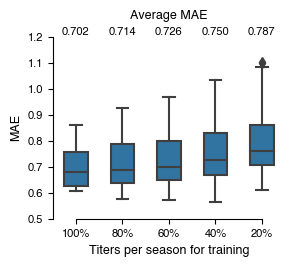

In [6]:
fig, ax = plt.subplots(figsize=(3,2.4))

plot = sns.boxplot(x='titers_train', y='MAE', data=scores[scores.season!='Average'],
                   width=0.5,
                   color="C0",
                   ax=ax)

# annotate
# convert titers_train from string with percent sign to float
scores['titers_train'] = scores.titers_train.str.rstrip('%').astype('int')
avg_MAE                = scores[scores.season=='Average'].groupby(['titers_train']).mean().MAE.sort_index(ascending=False)
for (xtick, label) in zip(plot.get_xticks(), avg_MAE):
    ax.text(xtick,
            1.21,
            f"{label:.3f}",
            horizontalalignment='center',
            fontsize=8,
            rotation=0)

ax.text(2, 1.27, "Average MAE", fontsize=9, horizontalalignment='center')

# configurations for figure
ax.set_xlabel('Titers per season for training', fontsize=9)
ax.set_ylabel('MAE', fontsize=9)
ax.set_ylim(bottom=0.5, top=1.21)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')